# **Analysis of various Selection Strategies to solve Cold Start Problem with YouTube Comments Dataset**




# Setup

## Get Distil and Submodlib from Decile Repo

In [ ]:
# Get DISTIL
!git clone https://github.com/decile-team/distil.git

# Get submodlib
!git clone https://github.com/decile-team/submodlib.git

fatal: destination path 'distil' already exists and is not an empty directory.
fatal: destination path 'submodlib' already exists and is not an empty directory.


## Installations

#### *Restart runtime from here after initial install is complete*

In [ ]:
# Installations for DISTIL
!cd distil && pip install -r distil/requirements/requirements.txt
!pip install -r distil/requirements/requirements.txt

# Required installations
!pip install transformers
!pip install datasets

# Installations for Submodlib
!pip install -e ./submodlib/

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'distil/requirements/requirements.txt'
Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple/
  Using cached sphinxcontrib_bibtex-2.6.2-py3-none-any.whl (40 kB)
  Using cached multipledispatch-0.6.0-py3-none-any.whl (11 kB)
  Using cached scikit-learn-0.23.0.tar.gz (7.2 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Obtaining file:///content/submodlib
  Installing build dependencies ... done
  Checking if build

## Imports

In [ ]:
# Standard imports
import copy
import html
import math
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import os
import pandas as pd
import random # Import for query size sampling
import re # Import for baseline regex matching
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import statistics as stat
import string
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
import unicodedata

# Imports for datasets
from collections import Counter
from datasets import Dataset as D
from datasets import load_dataset, load_metric, concatenate_datasets
from io import BytesIO
import requests
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset, ConcatDataset
from tqdm.auto import tqdm
import zipfile

# Additional Imports
from transformers import AutoTokenizer, get_scheduler, BertConfig, AdamW, BertModel

# Imports for active learning
sys.path.append('submodlib/')
sys.path.append('distil/')
from distil.active_learning_strategies import BADGE, SMI, EntropySampling, LeastConfidenceSampling, MarginSampling, RandomSampling, KMeansSampling   # All active learning strategies showcased in this example
from distil.utils.utils import LabeledToUnlabeledDataset # A utility wrapper class that removes labels from labeled PyTorch dataset objects

## Download GloVe vectorizer

In [ ]:
# Get a simple tokenizer from torchtext. Use GloVe embeddings from torchtext, which will automatically download them.
glove_tokenizer     = get_tokenizer("basic_english")
glove_vectorizer    = GloVe(name='6B', dim=300)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [01:01<00:00, 6528.56it/s]


The above procedure should take 15-30 minutes. The rest of the code should run quicker.

# Data loading, sampling and pre-processing

## Load data from UCI_ML/Github Repository

In [ ]:
# URL of the ZIP file containing the YouTube Spam Collection dataset
zip_url = 'https://archive.ics.uci.edu/static/public/380/youtube+spam+collection.zip'

# Send a GET request to the ZIP file URL
response = requests.get(zip_url, verify=False)

# Extract the ZIP file in memory
with zipfile.ZipFile(BytesIO(response.content), 'r') as zip_ref:
    # Extract all the files from the ZIP archive
    zip_ref.extractall()

# List the files extracted from the ZIP archive
file_list = zip_ref.namelist()

# List to store individual DataFrames
dataframes = []

# Loop through the CSV files and load them into DataFrames
for file_name in file_list:
    if (file_name[0] != '_'):
        df = pd.read_csv(file_name, on_bad_lines='skip')
        dataframes.append(df)

# Concatenate all the DataFrames into one
youtube_df = pd.concat(dataframes, ignore_index=True)

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'archive.ics.uci.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


### Drop irrelevant columns and rename the rest

In [ ]:
# Drop the specified columns
columns_to_drop = ['COMMENT_ID', 'AUTHOR', 'DATE']
youtube_df = youtube_df.drop(columns=columns_to_drop)

# Rename the columns
youtube_df = youtube_df.rename(columns={'CONTENT': 'text', 'CLASS': 'labels'})

In [ ]:
youtube_df.head(10)

,text,labels
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1
5,"Hey, check out my new website!! This site is a...",1
6,Subscribe to my channel ﻿,1
7,i turned it on mute as soon is i came on i jus...,0
8,You should check my channel for Funny VIDEOS!!﻿,1
9,and u should.d check my channel and tell me wh...,1


## Define data pre-processing

### Text pre-processing

In [ ]:
# NLTK Downloads
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Set of punctuation special characters to remove from text
punctuation = set(string.punctuation)

# List of stopwords (commonly used words in English)
english_stopwords = set(stopwords.words('english'))

In [ ]:
# Converts all text to lowercase
def to_lower(text):
    return text.lower()

# Removes punctuation from the text
def remove_punc(text):
    return ''.join(x if x not in punctuation else ' ' for x in text)

# Decodes HTML entities and converts accented text to normal
def to_ascii(text):
    decoded_text = html.unescape(text)  # Decoding HTML entities
    return ''.join(x for x in unicodedata.normalize('NFD', decoded_text) if unicodedata.category(x) != 'Mn')

# Removes stopwords
def remove_stopwords(text):
    return ' '.join(x for x in word_tokenize(text) if x not in english_stopwords)

# Removes BOM Unicode
def remove_bom(text):
    return text.replace('\ufeff', '')

# Remove excess whitespace
def remove_xtra(text):
    return ' '.join(text.split()).strip()

# Process the data by making all text lowercase, removing puncuation, removing stopwords, and converting to ascii
def process_data(data):
    data['text'] = data['text'].apply(to_lower)
    data['text'] = data['text'].apply(to_ascii)
    data['text'] = data['text'].apply(remove_punc)
    data['text'] = data['text'].apply(remove_stopwords)
    data['text'] = data['text'].apply(remove_bom)
    data['text'] = data['text'].apply(remove_xtra)
    return data

### GloVe embeddings

In [ ]:
# Create a full dataset wrapper. This will return a dictionary of 3 items:
#   1. glove_embeddings:    The embedding vectors for the sentence, padded to the max length.
#   2. input_mask:          A tensor that denotes the start idx of the padded part of the sequence
#   3. labels:              A single-element tensor denoting the class.
#
# Creating such an object this way will allow us to utilize DISTIL's interfaces without issue and will also be compatible with the model defined above.
class FullDatasetWrapper(Dataset):

    # Here's how we can get embeddings for each sentence. This will create a list of tensors, which will have varying sizes.
    # We will need to pad each tensor for batching, so we will also need to keep track of the actual final token in each batch so that we do not compute on padded input.
    def __init__(self, datalist, labels):
        self.glove_embeddings   = [glove_vectorizer.get_vecs_by_tokens(glove_tokenizer(data_text), lower_case_backup=True) for data_text in datalist] # Convert text into glove embeddings
        self.labels             = torch.tensor(labels)
        self.pad_length         = max([glove_embedding.shape[0] for glove_embedding in self.glove_embeddings]) # Max sequence length


    def __init__(self, dataframe):
        self.glove_embeddings = []
        valid_labels = []
        for ind in dataframe.index:
            data_text, data_label = dataframe['text'][ind], dataframe['labels'][ind]
            tokens = glove_tokenizer(data_text)
            if not tokens:   # Check if token list is empty
                # print(f"Warning: No tokens for text: {data_text}")
                continue
            glove_embedding = glove_vectorizer.get_vecs_by_tokens(tokens, lower_case_backup=True)
            if glove_embedding.shape[0] == 0:  # Check if no embeddings found
                # print(f"Warning: No embeddings for tokens: {tokens} in text: {data_text}")
                continue
            self.glove_embeddings.append(glove_embedding)
            valid_labels.append(data_label)
        self.labels             = torch.tensor(valid_labels)
        self.pad_length         = max([glove_embedding.shape[0] for glove_embedding in self.glove_embeddings]) # Max sequence length

    def __getitem__(self, index):
        glove_embedding                                     = self.glove_embeddings[index]                              # Get the glove embeddings for sentence
        padded_glove_embedding                              = torch.zeros(self.pad_length, glove_embedding.shape[1])    # Create a padded tensor of zeros to hold them
        padded_glove_embedding[:glove_embedding.shape[0]]   = glove_embedding                                           # Populate the front of the tensor w/ glove embeddings
        input_mask                                          = torch.tensor(glove_embedding.shape[0])                    # Create a single-element tensor denoting index to start ignoring hidden states
        label                                               = self.labels[index]                                        # Get the label and form the dictionary.
        item_dict                                           =   {"glove_embeddings":    padded_glove_embedding,
                                                                "input_mask":           input_mask,
                                                                "labels":               label}
        return item_dict

    def __len__(self):
        return len(self.glove_embeddings)

### AL Label Removal

In [ ]:
class Labeled_to_unlabel(Dataset):

  def __init__(self, wrapped_dataset):
        self.wrapped_dataset = wrapped_dataset
        # give the words here

  def __getitem__(self, index):

        #label = self.wrapped_dataset[index]['labels']
        data = {key:self.wrapped_dataset[index][key] for key in self.wrapped_dataset[index] if key != 'labels'}

        #data = self.wrapped_dataset[index]
        return data

  def __len__(self):
        return len(self.wrapped_dataset)

## Data split and sampling

In [ ]:
seed_values = [42, 96, 35, 52, 11, 87, 26, 75, 60, 49]

#### *Use Ctrl+F10 from here for experiment re-runs (after changing exp_num)*

In [ ]:
exp_num = 10 # CHANGE ME

In [ ]:
# DEFINE RAND_STATE FOR EXPERIMENT RUN
RAND_STATE = seed_values[exp_num-1]
print('Experiment number: {} \tSeed value = {}'.format(exp_num, RAND_STATE))
with open('logs.txt', 'a') as logfile:
    logfile.write('\n\nExperiment number: {} \tSeed value = {}  [YouTube Data]\n'.format(exp_num, RAND_STATE))

Experiment number: 10 	Seed value = 49


### Create test-train split

In [ ]:
# Specify the features (X) and target (y) columns
X = youtube_df.drop(columns=['labels'])
y = youtube_df['labels']

# Perform the train-test split while maintaining the same class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=RAND_STATE, stratify=y)

# Create the train_df and test_df DataFrames
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

### Create imbalance in training data (YouTube Dataset only)

In [ ]:
# Create an approximate 1:10 imbalance with spam to non-spam data
ham_train = train_df[train_df['labels']==0]
spam_train = train_df[train_df['labels']==1]
spam_reduced = spam_train.sample(frac=0.1, random_state=RAND_STATE)
imbalance_df = pd.concat([ham_train, spam_reduced], ignore_index=True)
train_mod_df = shuffle(imbalance_df, random_state=RAND_STATE)

### Find data distribution and calculate imbalance factor

In [ ]:
print('\t  Ham   Spam')
print('Initial  ', ham_train.shape[0], '  ', spam_train.shape[0])
train_class_counts = train_mod_df['labels'].value_counts()
print('Training ', train_class_counts[0], '  ', train_class_counts[1])
test_class_counts = test_df['labels'].value_counts()
print('Testing  ', test_class_counts[0], '  ', test_class_counts[1])

	  Ham   Spam
Initial   808    854
Training  808    85
Testing   143    151


In [ ]:
print("Rare class to majority class ratio ~ 1 :", round(train_class_counts[0]/train_class_counts[1]))

Rare class to majority class ratio ~ 1 : 10


In [ ]:
a, b = len(test_df), len(train_mod_df)
print("Effective test-train split = {}:{}".format(round((100*a)/(a+b)), round((100*b)/(a+b))))

Effective test-train split = 25:75


### Create query set

In [ ]:
# List of commonly found phrases in youtube spam comments
freq_yt_spam_phrases = [
    'check out my latest video', 'click the link', 'dont miss out', 'https',
    'for more information', 'free gift', 'free giveaway', 'win prizes',
    'like and comment', 'limited time offer', 'please help', 'subscribe now',
    'subscribe to my channel', 'visit my website', 'watch my video'
]
query_set_size = len(freq_yt_spam_phrases)
query_data = pd.DataFrame({
    'text':freq_yt_spam_phrases, 'labels': [1]*query_set_size
})

## Apply pre-processing

### Apply text processing

In [ ]:
train_processed_df = process_data(train_mod_df)
# train_processed_df.iloc[10:25]
train_processed_df.head()

,text,labels
875,sneakiestg good music hood muzik subscribe 2 c...,1
876,great warning happen soon 0 lneadw26bfst76vhkj...,1
126,pisses bit blank space views 868 mio meh,0
519,shakira beautiful,0
796,song special song africa african,0


In [ ]:
query_df = process_data(query_data)
query_df.head()

,text,labels
0,check latest video,1
1,click link,1
2,dont miss,1
3,https,1
4,information,1


In [ ]:
test_df = process_data(test_df)

### Get dataset with embeddings

In [ ]:
# GloVe Embeddings for Training Dataset
training_dataset = FullDatasetWrapper(train_processed_df)
# GloVe Embeddings for Query Datas
rare_class_query_set = FullDatasetWrapper(query_df)
# GloVe Embeddings for Testing Dataset
testing_dataset = FullDatasetWrapper(test_df)

# Custom LSTM Model

## Model Definition

In [ ]:
class Average(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, batch_sentence_token_embeddings, input_mask):
        avgs = []
        with torch.no_grad():
            for i in range(batch_sentence_token_embeddings.shape[0]):
                avg = torch.mean(batch_sentence_token_embeddings[i,:input_mask[i],:], dim=0)
                avgs.append(avg)
        return torch.stack(avgs, dim=0)


class SimpleGloVeRNN(nn.Module):

    def __init__(self, num_classes, hidden_dim=512, embedding_dim=256, num_rnn_stacks=1, num_mlp_layers=1):

        super().__init__()
        self.average  = Average()
        self.rnn      = nn.LSTM(batch_first=True, input_size=300, hidden_size=hidden_dim, num_layers=num_rnn_stacks)
        self.activ    = nn.ReLU()

        mlp_layers  = []
        for i in range(num_mlp_layers - 1):
            linear      = nn.Linear(hidden_dim, hidden_dim)
            bn          = nn.BatchNorm1d(hidden_dim)
            mlp_layers.append(linear)
            mlp_layers.append(bn)
            mlp_layers.append(self.activ)
        embed_linear    = nn.Linear(hidden_dim, embedding_dim)
        embed_bn        = nn.BatchNorm1d(hidden_dim)
        mlp_layers.append(embed_linear)
        mlp_layers.append(embed_bn)

        self.mlp            = nn.Sequential(*mlp_layers)
        self.cls            = nn.Linear(embedding_dim, num_classes)
        self.embedding_dim  = embedding_dim
        self.hidden_dim     = hidden_dim


    def get_embedding_dim(self):
        return self.embedding_dim


    def forward(self, glove_embeddings, input_mask, labels=None, freeze=False, last=False):

        if freeze:
            with torch.no_grad():
                ignore_this         = self.average(glove_embeddings, input_mask)
                hidden_states, _    = self.rnn(glove_embeddings)
                # last_hidden_states  = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1).squeeze()  # Using the mask, get the hidden vectors that correspond to the end of each sequence in the batch.
                last_hidden_states = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1)
                if last_hidden_states.size(1) == 1:
                    last_hidden_states = last_hidden_states.squeeze(1) # Squeeze the second dimension if it's 1
                else:
                    last_hidden_states = last_hidden_states.squeeze() # Or just squeeze the last dimension
                # print(last_hidden_states.shape, glove_embeddings.shape, input_mask.shape)
                sentence_embed      = self.mlp(last_hidden_states)
        else:
            ignore_this         = self.average(glove_embeddings, input_mask)                                                            # Added so we can use hooks to get input values for DISTIL's SMI.
            hidden_states, _    = self.rnn(glove_embeddings)                                                                            # Apply RNN
            # last_hidden_states  = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1).squeeze()  # Using the mask, get the hidden vectors that correspond to the end of each sequence in the batch.
            last_hidden_states = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1)
            if last_hidden_states.size(1) == 1:
                last_hidden_states = last_hidden_states.squeeze(1) # Squeeze the second dimension if it's 1
            else:
                last_hidden_states = last_hidden_states.squeeze() # Or just squeeze the last dimension
            # print(last_hidden_states.shape, glove_embeddings.shape, input_mask.shape)
            sentence_embed      = self.mlp(last_hidden_states)                                                                          # Then, apply the MLP on top of the hidden states.
        logits  = self.cls(self.activ(sentence_embed))
        if last:
            return logits, sentence_embed
        else:
            return logits

## Custom Training Method

In [ ]:
class data_train:

    def __init__(self, num_cls=2, hidden_dim=256, embedding_dim=256, num_rnn_stacks=2, mlp_layers=2, batch_size=20) -> None:
        self.model = SimpleGloVeRNN(num_cls, hidden_dim, embedding_dim, num_rnn_stacks, mlp_layers)
        self.num_cls = num_cls
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.num_rnn_stacks = num_rnn_stacks
        self.mlp_layers = mlp_layers
        self.batch_size = batch_size
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)

    def get_param_count(self):
        # How many parameters? Should be MUCH less than BERT (110 million)! Can configure above params to make the model larger/smaller.
        param_count = 0
        for param in self.model.parameters():
            size_list   = param.size()
            param_count += torch.prod(torch.tensor(size_list)).item()
        print("Parameters:", F"{param_count:,}")
        return param_count

    def check_batching(self, training_dataset):
        dataloader = DataLoader(training_dataset, batch_size=2, shuffle=False)
        for batch_dict in dataloader:
            batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
            output = self.model(**batch_dict)
            print(output.shape)

    def train(self, training_dataset, epochs=150, lr=1e-2):
        dataloader = DataLoader(training_dataset, batch_size=self.batch_size, shuffle=False)
        optimizer = optim.SGD(self.model.parameters(), lr=1e-2)
        self.model.train()
        losses = []
        for i in range(epochs):
            epoch_loss, num_batches = 0, 0
            for batch_dict in dataloader:
                batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
                optimizer.zero_grad()
                out   = self.model(**batch_dict)
                loss  = torch.nn.functional.cross_entropy(out, batch_dict["labels"])
                loss.backward()
                optimizer.step()
                epoch_loss, num_batches = epoch_loss+loss.item(), num_batches+1
            avg_loss = epoch_loss/num_batches if num_batches>0 else 0
            if (i+1)%5==0:
                print('Epoch:', (i+1), '\tLoss =', avg_loss)
            losses.append(avg_loss)
        self.model.eval()
        return losses

    def verify_output_emeddings(self, training_dataset):
        dataloader = DataLoader(training_dataset, batch_size=2, shuffle=False)
        for batch_dict in dataloader:
            batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
            output, embeddings = self.model(**batch_dict, last=True, freeze=True)
            print(output)
            print(embeddings.shape)

    def get_test_metrics(self, testing_dataset):
        dataloader = DataLoader(testing_dataset, batch_size=self.batch_size, shuffle=False)
        # Initialize counters
        tp = fp = fn = tn = 0

        self.model.eval()
        with torch.no_grad():
            for batch_dict in dataloader:
                batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
                # Get model outputs
                outputs = self.model(**batch_dict)
                # Calculate predictions from outputs (assuming binary classification with threshold at 0.5)
                # Modify the threshold and prediction calculation if necessary
                predictions = torch.argmax(outputs, dim=1)
                # Get true labels
                true_labels = batch_dict["labels"]
                # Update confusion matrix
                conf_mat = confusion_matrix(true_labels.cpu().numpy(), predictions.cpu().numpy(), labels=[0, 1])
                tn_, fp_, fn_, tp_ = conf_mat.ravel() if conf_mat.size == 4 else (0, 0, 0, 0)
                tp, fp, fn, tn = tp+tp_, fp+fp_, fn+fn_, tn+tn_

        acc = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (tp + fn) if (tp + fn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        fdr = fp / (tp + fp) if (tp + fp) > 0 else 0
        mcc_numerator = (tp * tn) - (fp * fn)
        mcc_denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
        mcc = mcc_numerator / mcc_denominator if mcc_denominator > 0 else 0

        metrics = {
            'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn, 'acc': acc, 'f1': f1,
            'ppv': ppv, 'tpr': tpr, 'fpr': fpr, 'fnr': fnr,
            'tnr': tnr, 'npv': npv, 'fdr': fdr, 'mcc': mcc
        }

        return metrics


### Metric_dict Definition

In [ ]:
metric_dict = {
    'tp': "True Positive Count", 'fp': 'False Positive Count',
    'fn': "False Negative Count", 'tn': 'True Negative Count',
    'acc': "Accuracy", 'f1': 'F1-score | F-measure',
    'ppv': "Positive Predictive Value | Precision",
    'tpr': 'True Positive Rate | Recall | Sensitivity',
    'fpr': "False Positive Rate | Type I error",
    'fnr': 'False Negative Rate | Type II error',
    'tnr': "True Negative Rate | Specificity",
    'npv': 'Negative Predictive Value', 'fdr': "False Discovery Rate",
    'mcc': 'Matthews Correlation Coefficient',

}
metric_dict

{'tp': 'True Positive Count',
 'fp': 'False Positive Count',
 'fn': 'False Negative Count',
 'tn': 'True Negative Count',
 'acc': 'Accuracy',
 'f1': 'F1-score | F-measure',
 'ppv': 'Positive Predictive Value | Precision',
 'tpr': 'True Positive Rate | Recall | Sensitivity',
 'fpr': 'False Positive Rate | Type I error',
 'fnr': 'False Negative Rate | Type II error',
 'tnr': 'True Negative Rate | Specificity',
 'npv': 'Negative Predictive Value',
 'fdr': 'False Discovery Rate',
 'mcc': 'Matthews Correlation Coefficient'}

# Active Learning

## Define Selection Strategy arguments

In [ ]:
budget = sum(train_class_counts)//20 # Budget is set to 5% of the total training dataset
print(budget)

44


In [ ]:
selection_strategy_args = {
    'device':        "cpu",                  # Use the device used in training
    'batch_size':    20,                    # Use the batch size used in training
    'metric':        'cosine',             # Use cosine similarity when determining the likeness of two data points
    'optimizer':     'LazyGreedy',          # When doing submodular maximization, use the lazy greedy optimizer
    'embedding_type': 'features',          # IMPORTANT: NEED TO USE PRETRAINED GLOVE FEATURES FOR COLD START SELECTION!
    'layer_name':    'average'             # We can do so by specifying the layer we wish to extract those features from.
}

## Facility Location: Second variant (query-set Q)

In [ ]:
LSTM_fl2mi = data_train()

### FLQMI Subset Selection

In [ ]:
selection_strategy_args['smi_function'] = 'fl2mi'
selection_strategy_args['device'] = LSTM_fl2mi.device
fl2mi_selection_strategy = SMI(training_dataset,Labeled_to_unlabel(training_dataset), rare_class_query_set, LSTM_fl2mi.model, LSTM_fl2mi.num_cls, selection_strategy_args)
fl2mi_selected_idx = fl2mi_selection_strategy.select(budget)
fl2mi_human_labeled_dataset = Subset(training_dataset, fl2mi_selected_idx)

fl2mi_class_counts = [0 for x in range(LSTM_fl2mi.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in fl2mi_human_labeled_dataset:
    fl2mi_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: FLQMI')
for class_idx, class_count in enumerate(fl2mi_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: FLQMI
Class 0 count: 19
Class 1 count: 25


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: FLQMI \n')
    for class_idx, class_count in enumerate(fl2mi_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on FLQMI Selection

In [ ]:
losses_fl2mi = LSTM_fl2mi.train(fl2mi_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.2959183951218923
Epoch: 10 	Loss = 0.18260986606280008
Epoch: 15 	Loss = 0.1252888316909472
Epoch: 20 	Loss = 0.09315760682026546
Epoch: 25 	Loss = 0.07227887958288193
Epoch: 30 	Loss = 0.05899600808819135
Epoch: 35 	Loss = 0.049018487334251404
Epoch: 40 	Loss = 0.04162677129109701
Epoch: 45 	Loss = 0.0363731582959493
Epoch: 50 	Loss = 0.031973560651143394


### Test Performance - FLQMI

In [ ]:
fl2mi_metrics = LSTM_fl2mi.get_test_metrics(testing_dataset)

In [ ]:
fl2mi_metrics

{'tp': 125,
 'fp': 42,
 'fn': 26,
 'tn': 101,
 'acc': 0.7687074829931972,
 'f1': 0.7861635220125787,
 'ppv': 0.7485029940119761,
 'tpr': 0.8278145695364238,
 'fpr': 0.2937062937062937,
 'fnr': 0.17218543046357615,
 'tnr': 0.7062937062937062,
 'npv': 0.7952755905511811,
 'fdr': 0.25149700598802394,
 'mcc': 0.5389217403616007}

In [ ]:
fl2mi_metrics['name'] = 'FLQMI'

## Facility Location: First variant (ground-set V)

In [ ]:
LSTM_fl1mi = data_train()

### FLVMI Subset Selection

In [ ]:
selection_strategy_args['smi_function'] = 'fl1mi'
selection_strategy_args['device'] = LSTM_fl1mi.device
fl1mi_selection_strategy = SMI(training_dataset,Labeled_to_unlabel(training_dataset), rare_class_query_set, LSTM_fl1mi.model, LSTM_fl1mi.num_cls, selection_strategy_args)
fl1mi_selected_idx = fl1mi_selection_strategy.select(budget)
fl1mi_human_labeled_dataset = Subset(training_dataset, fl1mi_selected_idx)

fl1mi_class_counts = [0 for x in range(LSTM_fl1mi.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in fl1mi_human_labeled_dataset:
    fl1mi_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: FLVMI')
for class_idx, class_count in enumerate(fl1mi_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: FLVMI
Class 0 count: 32
Class 1 count: 12


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: FLVMI \n')
    for class_idx, class_count in enumerate(fl1mi_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on FLVMI Selection

In [ ]:
losses_fl1mi = LSTM_fl1mi.train(fl1mi_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.18467429280281067
Epoch: 10 	Loss = 0.10086724410454433
Epoch: 15 	Loss = 0.06755505874752998
Epoch: 20 	Loss = 0.04979589767754078
Epoch: 25 	Loss = 0.038975564762949944
Epoch: 30 	Loss = 0.03164133243262768
Epoch: 35 	Loss = 0.02659185789525509
Epoch: 40 	Loss = 0.02283553158243497
Epoch: 45 	Loss = 0.01994498912245035
Epoch: 50 	Loss = 0.017686201725155115


### Test Performance - FLVMI

In [ ]:
fl1mi_metrics = LSTM_fl1mi.get_test_metrics(testing_dataset)

In [ ]:
fl1mi_metrics

{'tp': 80,
 'fp': 8,
 'fn': 71,
 'tn': 135,
 'acc': 0.7312925170068028,
 'f1': 0.6694560669456067,
 'ppv': 0.9090909090909091,
 'tpr': 0.5298013245033113,
 'fpr': 0.055944055944055944,
 'fnr': 0.47019867549668876,
 'tnr': 0.9440559440559441,
 'npv': 0.6553398058252428,
 'fdr': 0.09090909090909091,
 'mcc': 0.5171649609758142}

In [ ]:
fl1mi_metrics['name'] = 'FLVMI'

## Log Determinant

In [ ]:
LSTM_logdetmi = data_train()

### LogDetMI Subset Selection

In [ ]:
selection_strategy_args['smi_function'] = 'logdetmi'
selection_strategy_args['device'] = LSTM_logdetmi.device
logdetmi_selection_strategy = SMI(training_dataset,Labeled_to_unlabel(training_dataset), rare_class_query_set, LSTM_logdetmi.model, LSTM_logdetmi.num_cls, selection_strategy_args)
logdetmi_selected_idx = logdetmi_selection_strategy.select(budget)
logdetmi_human_labeled_dataset = Subset(training_dataset, logdetmi_selected_idx)

logdetmi_class_counts = [0 for x in range(LSTM_logdetmi.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in logdetmi_human_labeled_dataset:
    logdetmi_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: LogDetMI')
for class_idx, class_count in enumerate(logdetmi_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: LogDetMI
Class 0 count: 20
Class 1 count: 24


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: LogDetMI \n')
    for class_idx, class_count in enumerate(logdetmi_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on LogDetMI Selection

In [ ]:
losses_logdetmi = LSTM_logdetmi.train(logdetmi_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.19817080597082773
Epoch: 10 	Loss = 0.10511292020479839
Epoch: 15 	Loss = 0.06958043078581493
Epoch: 20 	Loss = 0.05121327812472979
Epoch: 25 	Loss = 0.040210617085297905
Epoch: 30 	Loss = 0.033021767934163414
Epoch: 35 	Loss = 0.02777875028550625
Epoch: 40 	Loss = 0.0239774485429128
Epoch: 45 	Loss = 0.021037075047691662
Epoch: 50 	Loss = 0.018716961145401


### Test Performance - LogDetMI

In [ ]:
logdetmi_metrics = LSTM_logdetmi.get_test_metrics(testing_dataset)

In [ ]:
logdetmi_metrics

{'tp': 127,
 'fp': 28,
 'fn': 24,
 'tn': 115,
 'acc': 0.8231292517006803,
 'f1': 0.8300653594771242,
 'ppv': 0.8193548387096774,
 'tpr': 0.8410596026490066,
 'fpr': 0.1958041958041958,
 'fnr': 0.15894039735099338,
 'tnr': 0.8041958041958042,
 'npv': 0.8273381294964028,
 'fdr': 0.18064516129032257,
 'mcc': 0.6459737876287959}

In [ ]:
logdetmi_metrics['name'] = 'LogDetMI'

## Graph Cut

In [ ]:
LSTM_gcmi = data_train()

### GCMI Subset Selection

In [ ]:
selection_strategy_args['smi_function'] = 'gcmi'
selection_strategy_args['device'] = LSTM_gcmi.device
gcmi_selection_strategy = SMI(training_dataset,Labeled_to_unlabel(training_dataset), rare_class_query_set, LSTM_gcmi.model, LSTM_gcmi.num_cls, selection_strategy_args)
gcmi_selected_idx = gcmi_selection_strategy.select(budget)
gcmi_human_labeled_dataset = Subset(training_dataset, gcmi_selected_idx)

gcmi_class_counts = [0 for x in range(LSTM_gcmi.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in gcmi_human_labeled_dataset:
    gcmi_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: GCMI')
for class_idx, class_count in enumerate(gcmi_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: GCMI
Class 0 count: 19
Class 1 count: 25


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: GCMI \n')
    for class_idx, class_count in enumerate(gcmi_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on GCMI Selection

In [ ]:
losses_gcmi = LSTM_gcmi.train(gcmi_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.3810649911562602
Epoch: 10 	Loss = 0.23474363734324774
Epoch: 15 	Loss = 0.1667549361785253
Epoch: 20 	Loss = 0.1256773260732492
Epoch: 25 	Loss = 0.1014606902996699
Epoch: 30 	Loss = 0.08588625490665436
Epoch: 35 	Loss = 0.07031003944575787
Epoch: 40 	Loss = 0.06121575397749742
Epoch: 45 	Loss = 0.053632679084936775
Epoch: 50 	Loss = 0.047994970033566155


### Test Performance - GCMI

In [ ]:
gcmi_metrics = LSTM_gcmi.get_test_metrics(testing_dataset)

In [ ]:
gcmi_metrics

{'tp': 75,
 'fp': 61,
 'fn': 76,
 'tn': 82,
 'acc': 0.5340136054421769,
 'f1': 0.5226480836236934,
 'ppv': 0.5514705882352942,
 'tpr': 0.4966887417218543,
 'fpr': 0.42657342657342656,
 'fnr': 0.5033112582781457,
 'tnr': 0.5734265734265734,
 'npv': 0.5189873417721519,
 'fdr': 0.4485294117647059,
 'mcc': 0.07028641381645488}

In [ ]:
gcmi_metrics['name'] = 'GCMI'

## RegEx Baseline

In [ ]:
LSTM_regex = data_train()

### Custom RegEx Sampling

In [ ]:
# Extract only the text (not labels) from the train_dataset after text processing
full_data_texts = train_processed_df['text'].tolist()
query_texts = query_df['text'].tolist()

# Function to count regex matches
def count_regex_matches(text, patterns):
    return sum([1 if re.search(pattern, text) else 0 for pattern in patterns])

# Count matches for each item in full_data_texts
match_counts = [count_regex_matches(text, query_texts) for text in full_data_texts]

# Extract the top k indices
regex_selected_idx = sorted(range(len(match_counts)), key=lambda i: match_counts[i], reverse=True)[:budget]
print(len(regex_selected_idx), regex_selected_idx[:budget//5])

44 [244, 333, 348, 397, 632, 0, 24, 32]


In [ ]:
regex_human_labeled_dataset = FullDatasetWrapper(train_processed_df.iloc[regex_selected_idx])
regex_class_counts = [0 for x in range(LSTM_regex.num_cls)] # Comment if repeating selection
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in regex_human_labeled_dataset:
    regex_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: RegEx Baseline')
for class_idx, class_count in enumerate(regex_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: RegEx Baseline
Class 0 count: 13
Class 1 count: 31


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: RegEx Baseline \n')
    for class_idx, class_count in enumerate(regex_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on RegEx Selection

In [ ]:
losses_regex = LSTM_regex.train(regex_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.534076472123464
Epoch: 10 	Loss = 0.4158482750256856
Epoch: 15 	Loss = 0.3330252319574356
Epoch: 20 	Loss = 0.26959014932314557
Epoch: 25 	Loss = 0.2224829619129499
Epoch: 30 	Loss = 0.18466734513640404
Epoch: 35 	Loss = 0.1544895035525163
Epoch: 40 	Loss = 0.13163171025613943
Epoch: 45 	Loss = 0.11387223315735658
Epoch: 50 	Loss = 0.10067276284098625


### Test Performance - RegEx

In [ ]:
regex_metrics = LSTM_regex.get_test_metrics(testing_dataset)

In [ ]:
regex_metrics

{'tp': 70,
 'fp': 19,
 'fn': 81,
 'tn': 124,
 'acc': 0.6598639455782312,
 'f1': 0.5833333333333334,
 'ppv': 0.7865168539325843,
 'tpr': 0.46357615894039733,
 'fpr': 0.13286713286713286,
 'fnr': 0.5364238410596026,
 'tnr': 0.8671328671328671,
 'npv': 0.6048780487804878,
 'fdr': 0.21348314606741572,
 'mcc': 0.3597746893352563}

In [ ]:
regex_metrics['name'] = 'RegEx'

## Random Strategy

In [ ]:
LSTM_random = data_train()

### Random Subset Selection

In [ ]:
selection_strategy_args['device'] = LSTM_random.device
random_selection_strategy = RandomSampling(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_random.model, LSTM_random.num_cls, selection_strategy_args)
random_selected_idx = random_selection_strategy.select(budget)
random_human_labeled_dataset = Subset(training_dataset, random_selected_idx)

random_class_counts = [0 for x in range(LSTM_random.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in random_human_labeled_dataset:
    random_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: Random')
for class_idx, class_count in enumerate(random_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: Random
Class 0 count: 42
Class 1 count: 2


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: Random \n')
    for class_idx, class_count in enumerate(random_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Random Selection

In [ ]:
losses_random = LSTM_random.train(random_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.11641467859347661
Epoch: 10 	Loss = 0.05960784976681074
Epoch: 15 	Loss = 0.04012407176196575
Epoch: 20 	Loss = 0.030253737544020016
Epoch: 25 	Loss = 0.024272585287690163
Epoch: 30 	Loss = 0.02028549090027809
Epoch: 35 	Loss = 0.01739474230756362
Epoch: 40 	Loss = 0.015206470154225826
Epoch: 45 	Loss = 0.013502170642217001
Epoch: 50 	Loss = 0.01212949895610412


### Test Performance - Random

In [ ]:
random_metrics = LSTM_random.get_test_metrics(testing_dataset)

In [ ]:
random_metrics

{'tp': 1,
 'fp': 0,
 'fn': 150,
 'tn': 143,
 'acc': 0.4897959183673469,
 'f1': 0.013157894736842105,
 'ppv': 1.0,
 'tpr': 0.006622516556291391,
 'fpr': 0.0,
 'fnr': 0.9933774834437086,
 'tnr': 1.0,
 'npv': 0.4880546075085324,
 'fdr': 0.0,
 'mcc': 0.056851998369446544}

In [ ]:
random_metrics['name'] = 'Random'

## BADGE - Batch Active learning by Diverse Gradient Embeddings

In [ ]:
LSTM_badge = data_train()

### BADGE Subset Selection

In [ ]:
selection_strategy_args['device'] = LSTM_badge.device
badge_selection_strategy = BADGE(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_badge.model, LSTM_badge.num_cls, selection_strategy_args)
badge_selected_idx = badge_selection_strategy.select(budget)
badge_human_labeled_dataset = Subset(training_dataset, badge_selected_idx)

badge_class_counts = [0 for x in range(LSTM_badge.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in badge_human_labeled_dataset:
    badge_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: BADGE')
for class_idx, class_count in enumerate(badge_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: BADGE
Class 0 count: 38
Class 1 count: 6


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: BADGE \n')
    for class_idx, class_count in enumerate(badge_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on BADGE Selection

In [ ]:
losses_badge = LSTM_badge.train(badge_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.16447114944458008
Epoch: 10 	Loss = 0.0884718547264735
Epoch: 15 	Loss = 0.059219093372424446
Epoch: 20 	Loss = 0.04376691083113352
Epoch: 25 	Loss = 0.03448943297068278
Epoch: 30 	Loss = 0.0283471221725146
Epoch: 35 	Loss = 0.023990299552679062
Epoch: 40 	Loss = 0.020736694956819218
Epoch: 45 	Loss = 0.018258882065614063
Epoch: 50 	Loss = 0.016310576039055984


### Test Performance - BADGE

In [ ]:
badge_metrics = LSTM_badge.get_test_metrics(testing_dataset)

In [ ]:
badge_metrics

{'tp': 16,
 'fp': 1,
 'fn': 135,
 'tn': 142,
 'acc': 0.5374149659863946,
 'f1': 0.19047619047619047,
 'ppv': 0.9411764705882353,
 'tpr': 0.10596026490066225,
 'fpr': 0.006993006993006993,
 'fnr': 0.8940397350993378,
 'tnr': 0.993006993006993,
 'npv': 0.5126353790613718,
 'fdr': 0.058823529411764705,
 'mcc': 0.21192572841876167}

In [ ]:
badge_metrics['name'] = 'BADGE'

## Entropy Sampling

In [ ]:
LSTM_entropy = data_train()

### Entropy Subset Selection

In [ ]:
selection_strategy_args['device'] = LSTM_entropy.device
entropy_selection_strategy = EntropySampling(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_entropy.model, LSTM_entropy.num_cls, selection_strategy_args)
entropy_selected_idx = entropy_selection_strategy.select(budget)
entropy_human_labeled_dataset = Subset(training_dataset, entropy_selected_idx)

entropy_class_counts = [0 for x in range(LSTM_entropy.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in entropy_human_labeled_dataset:
    entropy_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: Entropy')
for class_idx, class_count in enumerate(entropy_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: Entropy
Class 0 count: 41
Class 1 count: 3


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: Entropy \n')
    for class_idx, class_count in enumerate(entropy_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Entropy Selection

In [ ]:
losses_entropy = LSTM_entropy.train(entropy_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.12599715838829675
Epoch: 10 	Loss = 0.06544934088985126
Epoch: 15 	Loss = 0.044943799575169883
Epoch: 20 	Loss = 0.03416993779440721
Epoch: 25 	Loss = 0.027551057438055675
Epoch: 30 	Loss = 0.02309826637307803
Epoch: 35 	Loss = 0.019808883778750896
Epoch: 40 	Loss = 0.017331760687132675
Epoch: 45 	Loss = 0.015384757270415625
Epoch: 50 	Loss = 0.01382782527556022


### Test Performance - Entropy

In [ ]:
entropy_metrics = LSTM_entropy.get_test_metrics(testing_dataset)

In [ ]:
entropy_metrics

{'tp': 0,
 'fp': 0,
 'fn': 151,
 'tn': 143,
 'acc': 0.48639455782312924,
 'f1': 0.0,
 'ppv': 0,
 'tpr': 0.0,
 'fpr': 0.0,
 'fnr': 1.0,
 'tnr': 1.0,
 'npv': 0.48639455782312924,
 'fdr': 0,
 'mcc': 0}

In [ ]:
entropy_metrics['name'] = 'Entropy'

## Least Confidence Sampling

In [ ]:
LSTM_leastconf = data_train()

### Least Confidence Subset Selection

In [ ]:
selection_strategy_args['device'] = LSTM_leastconf.device
leastconf_selection_strategy = LeastConfidenceSampling(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_leastconf.model, LSTM_leastconf.num_cls, selection_strategy_args)
leastconf_selected_idx = leastconf_selection_strategy.select(budget)
leastconf_human_labeled_dataset = Subset(training_dataset, leastconf_selected_idx)

leastconf_class_counts = [0 for x in range(LSTM_leastconf.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in leastconf_human_labeled_dataset:
    leastconf_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: Least Confidence')
for class_idx, class_count in enumerate(leastconf_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: Least Confidence
Class 0 count: 40
Class 1 count: 4


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: Least Confidence \n')
    for class_idx, class_count in enumerate(leastconf_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Least Confidence Selection

In [ ]:
losses_leastconf = LSTM_leastconf.train(leastconf_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.12739119678735733
Epoch: 10 	Loss = 0.07184045761823654
Epoch: 15 	Loss = 0.05014903967579206
Epoch: 20 	Loss = 0.03823846826950709
Epoch: 25 	Loss = 0.03078102630873521
Epoch: 30 	Loss = 0.025710489600896835
Epoch: 35 	Loss = 0.02207337940732638
Epoch: 40 	Loss = 0.01929389468083779
Epoch: 45 	Loss = 0.017127427582939465
Epoch: 50 	Loss = 0.01539195484171311


### Test Performance - Least Confidence

In [ ]:
leastconf_metrics = LSTM_leastconf.get_test_metrics(testing_dataset)

In [ ]:
leastconf_metrics

{'tp': 3,
 'fp': 0,
 'fn': 148,
 'tn': 143,
 'acc': 0.4965986394557823,
 'f1': 0.03896103896103896,
 'ppv': 1.0,
 'tpr': 0.019867549668874173,
 'fpr': 0.0,
 'fnr': 0.9801324503311258,
 'tnr': 1.0,
 'npv': 0.49140893470790376,
 'fdr': 0.0,
 'mcc': 0.09880835702529328}

In [ ]:
leastconf_metrics['name'] = 'Least_Conf'

## Margin Sampling

In [ ]:
LSTM_margin = data_train()

### Margin Subset Selection

In [ ]:
selection_strategy_args['device'] = LSTM_margin.device
margin_selection_strategy = MarginSampling(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_margin.model, LSTM_margin.num_cls, selection_strategy_args)
margin_selected_idx = margin_selection_strategy.select(budget)
margin_human_labeled_dataset = Subset(training_dataset, margin_selected_idx)

margin_class_counts = [0 for x in range(LSTM_margin.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in margin_human_labeled_dataset:
    margin_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: Margin')
for class_idx, class_count in enumerate(margin_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: Margin
Class 0 count: 43
Class 1 count: 1


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: Margin \n')
    for class_idx, class_count in enumerate(margin_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Margin Selection

In [ ]:
losses_margin = LSTM_margin.train(margin_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.09548819065093994
Epoch: 10 	Loss = 0.046852183838685356
Epoch: 15 	Loss = 0.031179428100585938
Epoch: 20 	Loss = 0.023429591829578083
Epoch: 25 	Loss = 0.018685700992743175
Epoch: 30 	Loss = 0.015514076376954714
Epoch: 35 	Loss = 0.013246062832574049
Epoch: 40 	Loss = 0.011542736242214838
Epoch: 45 	Loss = 0.010246426798403263
Epoch: 50 	Loss = 0.009213435929268599


### Test Performance - Margin

In [ ]:
margin_metrics = LSTM_margin.get_test_metrics(testing_dataset)

In [ ]:
margin_metrics

{'tp': 0,
 'fp': 0,
 'fn': 151,
 'tn': 143,
 'acc': 0.48639455782312924,
 'f1': 0.0,
 'ppv': 0,
 'tpr': 0.0,
 'fpr': 0.0,
 'fnr': 1.0,
 'tnr': 1.0,
 'npv': 0.48639455782312924,
 'fdr': 0,
 'mcc': 0}

In [ ]:
margin_metrics['name'] = 'Margin'

## KMeans Sampling

In [ ]:
LSTM_kmeans = data_train()

### KMeans Subset Selection

In [ ]:
selection_strategy_args['device']         = LSTM_kmeans.device
selection_strategy_args['representation'] = "raw"

# Get average glove embeddings of all unlabeled points, which can be done via the model
dummy_strategy      = MarginSampling(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_kmeans.model, LSTM_kmeans.num_cls, selection_strategy_args)
extracted_features  = dummy_strategy.get_feature_embedding(Labeled_to_unlabel(training_dataset), True, layer_name='average')

class TensorDataset(Dataset):
    def __init__(self, feature_tensor):
        self.feature_tensor = feature_tensor


    def __getitem__(self, index):
        return self.feature_tensor[index]


    def __len__(self):
        return self.feature_tensor.shape[0]

sel_dataset = TensorDataset(extracted_features)
kmeans_selection_strategy = KMeansSampling(sel_dataset, sel_dataset, LSTM_kmeans.model, LSTM_kmeans.num_cls, selection_strategy_args)
kmeans_selected_idx = kmeans_selection_strategy.select(budget)
kmeans_human_labeled_dataset = Subset(training_dataset, kmeans_selected_idx)

kmeans_class_counts = [0 for x in range(LSTM_kmeans.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in kmeans_human_labeled_dataset:
    kmeans_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: KMeans')
for class_idx, class_count in enumerate(kmeans_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: KMeans
Class 0 count: 41
Class 1 count: 3


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: KMeans \n')
    for class_idx, class_count in enumerate(kmeans_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on KMeans Selection

In [ ]:
losses_kmeans = LSTM_kmeans.train(kmeans_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.1108445053299268
Epoch: 10 	Loss = 0.05744526907801628
Epoch: 15 	Loss = 0.03830481072266897
Epoch: 20 	Loss = 0.028630999227364857
Epoch: 25 	Loss = 0.022782156864802044
Epoch: 30 	Loss = 0.018901099761327107
Epoch: 35 	Loss = 0.016072999065121014
Epoch: 40 	Loss = 0.01397142248849074
Epoch: 45 	Loss = 0.01234108613183101
Epoch: 50 	Loss = 0.011046135487655798


### Test Performance - KMeans

In [ ]:
kmeans_metrics = LSTM_kmeans.get_test_metrics(testing_dataset)

In [ ]:
kmeans_metrics

{'tp': 22,
 'fp': 1,
 'fn': 129,
 'tn': 142,
 'acc': 0.5578231292517006,
 'f1': 0.25287356321839083,
 'ppv': 0.9565217391304348,
 'tpr': 0.1456953642384106,
 'fpr': 0.006993006993006993,
 'fnr': 0.8543046357615894,
 'tnr': 0.993006993006993,
 'npv': 0.5239852398523985,
 'fdr': 0.043478260869565216,
 'mcc': 0.25816167542411594}

In [ ]:
kmeans_metrics['name'] = 'KMeans'

# Experiment Results

## Graph - Training Losses

In [ ]:
def plot_multiple_losses(loss_dict):
    plt.figure(figsize=(16, 6))
    for strat,losses in loss_dict.items():
        plt.plot(losses, label=strat)
    plt.title('Training Losses for different Selection Strategies: Exp {} [YouTube Data]'.format(exp_num))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

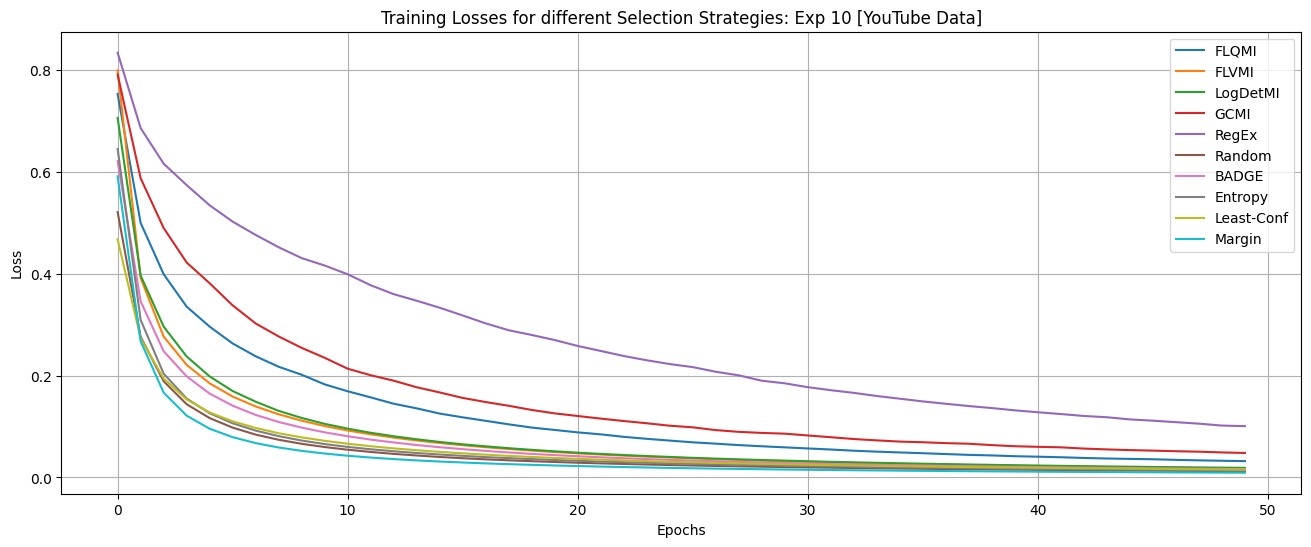

In [ ]:
plot_multiple_losses({
    'FLQMI': losses_fl2mi, 'FLVMI': losses_fl1mi,
    'LogDetMI': losses_logdetmi, 'GCMI': losses_gcmi,
    'RegEx': losses_regex, 'Random': losses_random,
    'BADGE': losses_badge, 'Entropy': losses_entropy,
    'Least-Conf': losses_leastconf, 'Margin': losses_margin,
    'KMeans': losses_kmeans
})

## Metric Compilation

In [ ]:
metric_list = [fl2mi_metrics, fl1mi_metrics, logdetmi_metrics, gcmi_metrics,
               regex_metrics, random_metrics, badge_metrics, entropy_metrics,
               leastconf_metrics, margin_metrics, kmeans_metrics]

In [ ]:
metrics_compiled = {k: {
    metric['name']: metric[k] for metric in metric_list
    } for k in metric_list[0] if (k!='name')}
metrics_compiled

{'tp': {'FLQMI': 125,
  'FLVMI': 80,
  'LogDetMI': 127,
  'GCMI': 75,
  'RegEx': 70,
  'Random': 1,
  'BADGE': 16,
  'Entropy': 0,
  'Least_Conf': 3,
  'Margin': 0},
 'fp': {'FLQMI': 42,
  'FLVMI': 8,
  'LogDetMI': 28,
  'GCMI': 61,
  'RegEx': 19,
  'Random': 0,
  'BADGE': 1,
  'Entropy': 0,
  'Least_Conf': 0,
  'Margin': 0},
 'fn': {'FLQMI': 26,
  'FLVMI': 71,
  'LogDetMI': 24,
  'GCMI': 76,
  'RegEx': 81,
  'Random': 150,
  'BADGE': 135,
  'Entropy': 151,
  'Least_Conf': 148,
  'Margin': 151},
 'tn': {'FLQMI': 101,
  'FLVMI': 135,
  'LogDetMI': 115,
  'GCMI': 82,
  'RegEx': 124,
  'Random': 143,
  'BADGE': 142,
  'Entropy': 143,
  'Least_Conf': 143,
  'Margin': 143},
 'acc': {'FLQMI': 0.7687074829931972,
  'FLVMI': 0.7312925170068028,
  'LogDetMI': 0.8231292517006803,
  'GCMI': 0.5340136054421769,
  'RegEx': 0.6598639455782312,
  'Random': 0.4897959183673469,
  'BADGE': 0.5374149659863946,
  'Entropy': 0.48639455782312924,
  'Least_Conf': 0.4965986394557823,
  'Margin': 0.48639455782

In [ ]:
with open('logs.txt', 'a') as tf:
    tf.write('\n\nExp{}_metrics'.format(exp_num))
    tf.write(' = {')
    for k in metric_list[0]:
        if (k!='name'):
            tf.write("'{}': ".format(k))
            tf.write('{')
            for metric in metric_list[:-1]:
                tf.write("'{}': {}, ".format(metric['name'], round(metric[k], 5)))
            tf.write("'{}': {}".format(metric_list[-1]['name'], round(metric_list[-1][k], 5)))
            tf.write('}, ')

with open('logs.txt', 'r') as tf:
    contents = tf.read()
contents = contents[:-2]
with open('logs.txt', 'w') as tf:
    tf.write(contents)
    tf.write('}')


NOTE: Execute only till here for each experimental run. After each run, copy metrics generated in above output cell or output txt file and paste in the below cell for the respective experiment. After completing all 10 experiments, run below cells only by uncommenting to generate mean metrics and performance graphs.

## Overall Metric Stats

In [ ]:
def get_stats(values):
    return {'range': (min(values), max(values)), 'avg': round(sum(values)/len(values), 5), 'std_dev': round(stat.stdev(values), 5)}

In [ ]:
def end_of_exp():
    Exp1_metrics = {'tp': {'FLQMI': 135, 'FLVMI': 66, 'LogDetMI': 130, 'GCMI': 104, 'RegEx': 55, 'Random': 19, 'BADGE': 16, 'Entropy': 0, 'Least_Conf': 15, 'Margin': 10}, 'fp': {'FLQMI': 53, 'FLVMI': 3, 'LogDetMI': 35, 'GCMI': 98, 'RegEx': 14, 'Random': 0, 'BADGE': 1, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 0}, 'fn': {'FLQMI': 16, 'FLVMI': 85, 'LogDetMI': 21, 'GCMI': 47, 'RegEx': 96, 'Random': 132, 'BADGE': 135, 'Entropy': 151, 'Least_Conf': 136, 'Margin': 141}, 'tn': {'FLQMI': 89, 'FLVMI': 139, 'LogDetMI': 107, 'GCMI': 44, 'RegEx': 128, 'Random': 142, 'BADGE': 141, 'Entropy': 142, 'Least_Conf': 142, 'Margin': 142}, 'acc': {'FLQMI': 0.76451, 'FLVMI': 0.69966, 'LogDetMI': 0.80887, 'GCMI': 0.50512, 'RegEx': 0.62457, 'Random': 0.54949, 'BADGE': 0.53584, 'Entropy': 0.48464, 'Least_Conf': 0.53584, 'Margin': 0.51877}, 'f1': {'FLQMI': 0.79646, 'FLVMI': 0.6, 'LogDetMI': 0.82278, 'GCMI': 0.58924, 'RegEx': 0.5, 'Random': 0.22353, 'BADGE': 0.19048, 'Entropy': 0.0, 'Least_Conf': 0.18072, 'Margin': 0.12422}, 'ppv': {'FLQMI': 0.71809, 'FLVMI': 0.95652, 'LogDetMI': 0.78788, 'GCMI': 0.51485, 'RegEx': 0.7971, 'Random': 1.0, 'BADGE': 0.94118, 'Entropy': 0, 'Least_Conf': 1.0, 'Margin': 1.0}, 'tpr': {'FLQMI': 0.89404, 'FLVMI': 0.43709, 'LogDetMI': 0.86093, 'GCMI': 0.68874, 'RegEx': 0.36424, 'Random': 0.12583, 'BADGE': 0.10596, 'Entropy': 0.0, 'Least_Conf': 0.09934, 'Margin': 0.06623}, 'fpr': {'FLQMI': 0.37324, 'FLVMI': 0.02113, 'LogDetMI': 0.24648, 'GCMI': 0.69014, 'RegEx': 0.09859, 'Random': 0.0, 'BADGE': 0.00704, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.10596, 'FLVMI': 0.56291, 'LogDetMI': 0.13907, 'GCMI': 0.31126, 'RegEx': 0.63576, 'Random': 0.87417, 'BADGE': 0.89404, 'Entropy': 1.0, 'Least_Conf': 0.90066, 'Margin': 0.93377}, 'tnr': {'FLQMI': 0.62676, 'FLVMI': 0.97887, 'LogDetMI': 0.75352, 'GCMI': 0.30986, 'RegEx': 0.90141, 'Random': 1.0, 'BADGE': 0.99296, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 1.0}, 'npv': {'FLQMI': 0.84762, 'FLVMI': 0.62054, 'LogDetMI': 0.83594, 'GCMI': 0.48352, 'RegEx': 0.57143, 'Random': 0.51825, 'BADGE': 0.51087, 'Entropy': 0.48464, 'Least_Conf': 0.51079, 'Margin': 0.50177}, 'fdr': {'FLQMI': 0.28191, 'FLVMI': 0.04348, 'LogDetMI': 0.21212, 'GCMI': 0.48515, 'RegEx': 0.2029, 'Random': 0.0, 'BADGE': 0.05882, 'Entropy': 0, 'Least_Conf': 0.0, 'Margin': 0.0}, 'mcc': {'FLQMI': 0.54279, 'FLVMI': 0.48993, 'LogDetMI': 0.61911, 'GCMI': -0.00151, 'RegEx': 0.31289, 'Random': 0.25536, 'BADGE': 0.21146, 'Entropy': 0, 'Least_Conf': 0.22526, 'Margin': 0.18229}}
    Exp2_metrics = {'tp': {'FLQMI': 145, 'FLVMI': 43, 'LogDetMI': 123, 'GCMI': 77, 'RegEx': 61, 'Random': 54, 'BADGE': 2, 'Entropy': 0, 'Least_Conf': 46, 'Margin': 24}, 'fp': {'FLQMI': 109, 'FLVMI': 4, 'LogDetMI': 33, 'GCMI': 17, 'RegEx': 14, 'Random': 3, 'BADGE': 0, 'Entropy': 0, 'Least_Conf': 3, 'Margin': 2}, 'fn': {'FLQMI': 6, 'FLVMI': 108, 'LogDetMI': 28, 'GCMI': 74, 'RegEx': 90, 'Random': 97, 'BADGE': 149, 'Entropy': 151, 'Least_Conf': 105, 'Margin': 127}, 'tn': {'FLQMI': 34, 'FLVMI': 139, 'LogDetMI': 110, 'GCMI': 126, 'RegEx': 129, 'Random': 140, 'BADGE': 143, 'Entropy': 143, 'Least_Conf': 140, 'Margin': 141}, 'acc': {'FLQMI': 0.60884, 'FLVMI': 0.61905, 'LogDetMI': 0.79252, 'GCMI': 0.69048, 'RegEx': 0.64626, 'Random': 0.65986, 'BADGE': 0.4932, 'Entropy': 0.48639, 'Least_Conf': 0.63265, 'Margin': 0.56122}, 'f1': {'FLQMI': 0.71605, 'FLVMI': 0.43434, 'LogDetMI': 0.8013, 'GCMI': 0.62857, 'RegEx': 0.53982, 'Random': 0.51923, 'BADGE': 0.02614, 'Entropy': 0.0, 'Least_Conf': 0.46, 'Margin': 0.27119}, 'ppv': {'FLQMI': 0.57087, 'FLVMI': 0.91489, 'LogDetMI': 0.78846, 'GCMI': 0.81915, 'RegEx': 0.81333, 'Random': 0.94737, 'BADGE': 1.0, 'Entropy': 0, 'Least_Conf': 0.93878, 'Margin': 0.92308}, 'tpr': {'FLQMI': 0.96026, 'FLVMI': 0.28477, 'LogDetMI': 0.81457, 'GCMI': 0.50993, 'RegEx': 0.40397, 'Random': 0.35762, 'BADGE': 0.01325, 'Entropy': 0.0, 'Least_Conf': 0.30464, 'Margin': 0.15894}, 'fpr': {'FLQMI': 0.76224, 'FLVMI': 0.02797, 'LogDetMI': 0.23077, 'GCMI': 0.11888, 'RegEx': 0.0979, 'Random': 0.02098, 'BADGE': 0.0, 'Entropy': 0.0, 'Least_Conf': 0.02098, 'Margin': 0.01399}, 'fnr': {'FLQMI': 0.03974, 'FLVMI': 0.71523, 'LogDetMI': 0.18543, 'GCMI': 0.49007, 'RegEx': 0.59603, 'Random': 0.64238, 'BADGE': 0.98675, 'Entropy': 1.0, 'Least_Conf': 0.69536, 'Margin': 0.84106}, 'tnr': {'FLQMI': 0.23776, 'FLVMI': 0.97203, 'LogDetMI': 0.76923, 'GCMI': 0.88112, 'RegEx': 0.9021, 'Random': 0.97902, 'BADGE': 1.0, 'Entropy': 1.0, 'Least_Conf': 0.97902, 'Margin': 0.98601}, 'npv': {'FLQMI': 0.85, 'FLVMI': 0.56275, 'LogDetMI': 0.7971, 'GCMI': 0.63, 'RegEx': 0.58904, 'Random': 0.59072, 'BADGE': 0.48973, 'Entropy': 0.48639, 'Least_Conf': 0.57143, 'Margin': 0.52612}, 'fdr': {'FLQMI': 0.42913, 'FLVMI': 0.08511, 'LogDetMI': 0.21154, 'GCMI': 0.18085, 'RegEx': 0.18667, 'Random': 0.05263, 'BADGE': 0.0, 'Entropy': 0, 'Least_Conf': 0.06122, 'Margin': 0.07692}, 'mcc': {'FLQMI': 0.28869, 'FLVMI': 0.35023, 'LogDetMI': 0.58468, 'GCMI': 0.4191, 'RegEx': 0.35093, 'Random': 0.4256, 'BADGE': 0.08054, 'Entropy': 0, 'Least_Conf': 0.38042, 'Margin': 0.25517}}
    Exp3_metrics = {'tp': {'FLQMI': 128, 'FLVMI': 58, 'LogDetMI': 72, 'GCMI': 107, 'RegEx': 85, 'Random': 6, 'BADGE': 19, 'Entropy': 0, 'Least_Conf': 24, 'Margin': 0}, 'fp': {'FLQMI': 39, 'FLVMI': 4, 'LogDetMI': 7, 'GCMI': 93, 'RegEx': 12, 'Random': 0, 'BADGE': 1, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 0}, 'fn': {'FLQMI': 23, 'FLVMI': 93, 'LogDetMI': 79, 'GCMI': 44, 'RegEx': 66, 'Random': 145, 'BADGE': 132, 'Entropy': 151, 'Least_Conf': 127, 'Margin': 151}, 'tn': {'FLQMI': 103, 'FLVMI': 138, 'LogDetMI': 135, 'GCMI': 49, 'RegEx': 130, 'Random': 142, 'BADGE': 141, 'Entropy': 142, 'Least_Conf': 142, 'Margin': 142}, 'acc': {'FLQMI': 0.7884, 'FLVMI': 0.66894, 'LogDetMI': 0.70648, 'GCMI': 0.53242, 'RegEx': 0.73379, 'Random': 0.50512, 'BADGE': 0.54608, 'Entropy': 0.48464, 'Least_Conf': 0.56655, 'Margin': 0.48464}, 'f1': {'FLQMI': 0.80503, 'FLVMI': 0.5446, 'LogDetMI': 0.62609, 'GCMI': 0.60969, 'RegEx': 0.68548, 'Random': 0.07643, 'BADGE': 0.22222, 'Entropy': 0.0, 'Least_Conf': 0.27429, 'Margin': 0.0}, 'ppv': {'FLQMI': 0.76647, 'FLVMI': 0.93548, 'LogDetMI': 0.91139, 'GCMI': 0.535, 'RegEx': 0.87629, 'Random': 1.0, 'BADGE': 0.95, 'Entropy': 0, 'Least_Conf': 1.0, 'Margin': 0}, 'tpr': {'FLQMI': 0.84768, 'FLVMI': 0.38411, 'LogDetMI': 0.47682, 'GCMI': 0.70861, 'RegEx': 0.56291, 'Random': 0.03974, 'BADGE': 0.12583, 'Entropy': 0.0, 'Least_Conf': 0.15894, 'Margin': 0.0}, 'fpr': {'FLQMI': 0.27465, 'FLVMI': 0.02817, 'LogDetMI': 0.0493, 'GCMI': 0.65493, 'RegEx': 0.08451, 'Random': 0.0, 'BADGE': 0.00704, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.15232, 'FLVMI': 0.61589, 'LogDetMI': 0.52318, 'GCMI': 0.29139, 'RegEx': 0.43709, 'Random': 0.96026, 'BADGE': 0.87417, 'Entropy': 1.0, 'Least_Conf': 0.84106, 'Margin': 1.0}, 'tnr': {'FLQMI': 0.72535, 'FLVMI': 0.97183, 'LogDetMI': 0.9507, 'GCMI': 0.34507, 'RegEx': 0.91549, 'Random': 1.0, 'BADGE': 0.99296, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 1.0}, 'npv': {'FLQMI': 0.81746, 'FLVMI': 0.5974, 'LogDetMI': 0.63084, 'GCMI': 0.52688, 'RegEx': 0.66327, 'Random': 0.49477, 'BADGE': 0.51648, 'Entropy': 0.48464, 'Least_Conf': 0.52788, 'Margin': 0.48464}, 'fdr': {'FLQMI': 0.23353, 'FLVMI': 0.06452, 'LogDetMI': 0.08861, 'GCMI': 0.465, 'RegEx': 0.12371, 'Random': 0.0, 'BADGE': 0.05, 'Entropy': 0, 'Least_Conf': 0.0, 'Margin': 0}, 'mcc': {'FLQMI': 0.57846, 'FLVMI': 0.43552, 'LogDetMI': 0.48148, 'GCMI': 0.05763, 'RegEx': 0.50806, 'Random': 0.14021, 'BADGE': 0.2354, 'Entropy': 0, 'Least_Conf': 0.28966, 'Margin': 0}}
    Exp4_metrics = {'tp': {'FLQMI': 72, 'FLVMI': 55, 'LogDetMI': 113, 'GCMI': 95, 'RegEx': 138, 'Random': 0, 'BADGE': 26, 'Entropy': 28, 'Least_Conf': 0, 'Margin': 0}, 'fp': {'FLQMI': 15, 'FLVMI': 2, 'LogDetMI': 30, 'GCMI': 54, 'RegEx': 108, 'Random': 0, 'BADGE': 1, 'Entropy': 3, 'Least_Conf': 0, 'Margin': 0}, 'fn': {'FLQMI': 79, 'FLVMI': 96, 'LogDetMI': 38, 'GCMI': 56, 'RegEx': 13, 'Random': 151, 'BADGE': 125, 'Entropy': 123, 'Least_Conf': 151, 'Margin': 151}, 'tn': {'FLQMI': 126, 'FLVMI': 139, 'LogDetMI': 111, 'GCMI': 87, 'RegEx': 33, 'Random': 141, 'BADGE': 140, 'Entropy': 138, 'Least_Conf': 141, 'Margin': 141}, 'acc': {'FLQMI': 0.67808, 'FLVMI': 0.66438, 'LogDetMI': 0.76712, 'GCMI': 0.62329, 'RegEx': 0.58562, 'Random': 0.48288, 'BADGE': 0.56849, 'Entropy': 0.56849, 'Least_Conf': 0.48288, 'Margin': 0.48288}, 'f1': {'FLQMI': 0.60504, 'FLVMI': 0.52885, 'LogDetMI': 0.76871, 'GCMI': 0.63333, 'RegEx': 0.69521, 'Random': 0.0, 'BADGE': 0.29213, 'Entropy': 0.30769, 'Least_Conf': 0.0, 'Margin': 0.0}, 'ppv': {'FLQMI': 0.82759, 'FLVMI': 0.96491, 'LogDetMI': 0.79021, 'GCMI': 0.63758, 'RegEx': 0.56098, 'Random': 0, 'BADGE': 0.96296, 'Entropy': 0.90323, 'Least_Conf': 0, 'Margin': 0}, 'tpr': {'FLQMI': 0.47682, 'FLVMI': 0.36424, 'LogDetMI': 0.74834, 'GCMI': 0.62914, 'RegEx': 0.91391, 'Random': 0.0, 'BADGE': 0.17219, 'Entropy': 0.18543, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fpr': {'FLQMI': 0.10638, 'FLVMI': 0.01418, 'LogDetMI': 0.21277, 'GCMI': 0.38298, 'RegEx': 0.76596, 'Random': 0.0, 'BADGE': 0.00709, 'Entropy': 0.02128, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.52318, 'FLVMI': 0.63576, 'LogDetMI': 0.25166, 'GCMI': 0.37086, 'RegEx': 0.08609, 'Random': 1.0, 'BADGE': 0.82781, 'Entropy': 0.81457, 'Least_Conf': 1.0, 'Margin': 1.0}, 'tnr': {'FLQMI': 0.89362, 'FLVMI': 0.98582, 'LogDetMI': 0.78723, 'GCMI': 0.61702, 'RegEx': 0.23404, 'Random': 1.0, 'BADGE': 0.99291, 'Entropy': 0.97872, 'Least_Conf': 1.0, 'Margin': 1.0}, 'npv': {'FLQMI': 0.61463, 'FLVMI': 0.59149, 'LogDetMI': 0.74497, 'GCMI': 0.60839, 'RegEx': 0.71739, 'Random': 0.48288, 'BADGE': 0.5283, 'Entropy': 0.52874, 'Least_Conf': 0.48288, 'Margin': 0.48288}, 'fdr': {'FLQMI': 0.17241, 'FLVMI': 0.03509, 'LogDetMI': 0.20979, 'GCMI': 0.36242, 'RegEx': 0.43902, 'Random': 0, 'BADGE': 0.03704, 'Entropy': 0.09677, 'Least_Conf': 0, 'Margin': 0}, 'mcc': {'FLQMI': 0.40474, 'FLVMI': 0.44133, 'LogDetMI': 0.53538, 'GCMI': 0.24607, 'RegEx': 0.20294, 'Random': 0, 'BADGE': 0.28479, 'Entropy': 0.26629, 'Least_Conf': 0, 'Margin': 0}}
    Exp5_metrics = {'tp': {'FLQMI': 107, 'FLVMI': 67, 'LogDetMI': 107, 'GCMI': 90, 'RegEx': 95, 'Random': 0, 'BADGE': 14, 'Entropy': 20, 'Least_Conf': 13, 'Margin': 14}, 'fp': {'FLQMI': 30, 'FLVMI': 5, 'LogDetMI': 25, 'GCMI': 62, 'RegEx': 20, 'Random': 0, 'BADGE': 1, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 1}, 'fn': {'FLQMI': 44, 'FLVMI': 84, 'LogDetMI': 44, 'GCMI': 61, 'RegEx': 56, 'Random': 151, 'BADGE': 137, 'Entropy': 131, 'Least_Conf': 138, 'Margin': 137}, 'tn': {'FLQMI': 113, 'FLVMI': 138, 'LogDetMI': 118, 'GCMI': 81, 'RegEx': 123, 'Random': 143, 'BADGE': 142, 'Entropy': 143, 'Least_Conf': 143, 'Margin': 142}, 'acc': {'FLQMI': 0.7483, 'FLVMI': 0.69728, 'LogDetMI': 0.76531, 'GCMI': 0.58163, 'RegEx': 0.7415, 'Random': 0.48639, 'BADGE': 0.53061, 'Entropy': 0.55442, 'Least_Conf': 0.53061, 'Margin': 0.53061}, 'f1': {'FLQMI': 0.74306, 'FLVMI': 0.6009, 'LogDetMI': 0.75618, 'GCMI': 0.59406, 'RegEx': 0.71429, 'Random': 0.0, 'BADGE': 0.16867, 'Entropy': 0.23392, 'Least_Conf': 0.15854, 'Margin': 0.16867}, 'ppv': {'FLQMI': 0.78102, 'FLVMI': 0.93056, 'LogDetMI': 0.81061, 'GCMI': 0.59211, 'RegEx': 0.82609, 'Random': 0, 'BADGE': 0.93333, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 0.93333}, 'tpr': {'FLQMI': 0.70861, 'FLVMI': 0.44371, 'LogDetMI': 0.70861, 'GCMI': 0.59603, 'RegEx': 0.62914, 'Random': 0.0, 'BADGE': 0.09272, 'Entropy': 0.13245, 'Least_Conf': 0.08609, 'Margin': 0.09272}, 'fpr': {'FLQMI': 0.20979, 'FLVMI': 0.03497, 'LogDetMI': 0.17483, 'GCMI': 0.43357, 'RegEx': 0.13986, 'Random': 0.0, 'BADGE': 0.00699, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.00699}, 'fnr': {'FLQMI': 0.29139, 'FLVMI': 0.55629, 'LogDetMI': 0.29139, 'GCMI': 0.40397, 'RegEx': 0.37086, 'Random': 1.0, 'BADGE': 0.90728, 'Entropy': 0.86755, 'Least_Conf': 0.91391, 'Margin': 0.90728}, 'tnr': {'FLQMI': 0.79021, 'FLVMI': 0.96503, 'LogDetMI': 0.82517, 'GCMI': 0.56643, 'RegEx': 0.86014, 'Random': 1.0, 'BADGE': 0.99301, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 0.99301}, 'npv': {'FLQMI': 0.71975, 'FLVMI': 0.62162, 'LogDetMI': 0.7284, 'GCMI': 0.57042, 'RegEx': 0.68715, 'Random': 0.48639, 'BADGE': 0.50896, 'Entropy': 0.5219, 'Least_Conf': 0.5089, 'Margin': 0.50896}, 'fdr': {'FLQMI': 0.21898, 'FLVMI': 0.06944, 'LogDetMI': 0.18939, 'GCMI': 0.40789, 'RegEx': 0.17391, 'Random': 0, 'BADGE': 0.06667, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.06667}, 'mcc': {'FLQMI': 0.49979, 'FLVMI': 0.47508, 'LogDetMI': 0.53639, 'GCMI': 0.16249, 'RegEx': 0.50112, 'Random': 0, 'BADGE': 0.19472, 'Entropy': 0.26292, 'Least_Conf': 0.20931, 'Margin': 0.19472}}
    Exp6_metrics = {'tp': {'FLQMI': 86, 'FLVMI': 52, 'LogDetMI': 112, 'GCMI': 104, 'RegEx': 56, 'Random': 0, 'BADGE': 6, 'Entropy': 79, 'Least_Conf': 0, 'Margin': 0}, 'fp': {'FLQMI': 7, 'FLVMI': 2, 'LogDetMI': 27, 'GCMI': 79, 'RegEx': 5, 'Random': 0, 'BADGE': 1, 'Entropy': 5, 'Least_Conf': 0, 'Margin': 0}, 'fn': {'FLQMI': 65, 'FLVMI': 99, 'LogDetMI': 39, 'GCMI': 47, 'RegEx': 95, 'Random': 151, 'BADGE': 145, 'Entropy': 72, 'Least_Conf': 151, 'Margin': 151}, 'tn': {'FLQMI': 134, 'FLVMI': 139, 'LogDetMI': 114, 'GCMI': 62, 'RegEx': 136, 'Random': 141, 'BADGE': 140, 'Entropy': 136, 'Least_Conf': 141, 'Margin': 141}, 'acc': {'FLQMI': 0.75342, 'FLVMI': 0.65411, 'LogDetMI': 0.77397, 'GCMI': 0.56849, 'RegEx': 0.65753, 'Random': 0.48288, 'BADGE': 0.5, 'Entropy': 0.7363, 'Least_Conf': 0.48288, 'Margin': 0.48288}, 'f1': {'FLQMI': 0.70492, 'FLVMI': 0.50732, 'LogDetMI': 0.77241, 'GCMI': 0.62275, 'RegEx': 0.5283, 'Random': 0.0, 'BADGE': 0.07595, 'Entropy': 0.67234, 'Least_Conf': 0.0, 'Margin': 0.0}, 'ppv': {'FLQMI': 0.92473, 'FLVMI': 0.96296, 'LogDetMI': 0.80576, 'GCMI': 0.56831, 'RegEx': 0.91803, 'Random': 0, 'BADGE': 0.85714, 'Entropy': 0.94048, 'Least_Conf': 0, 'Margin': 0}, 'tpr': {'FLQMI': 0.56954, 'FLVMI': 0.34437, 'LogDetMI': 0.74172, 'GCMI': 0.68874, 'RegEx': 0.37086, 'Random': 0.0, 'BADGE': 0.03974, 'Entropy': 0.52318, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fpr': {'FLQMI': 0.04965, 'FLVMI': 0.01418, 'LogDetMI': 0.19149, 'GCMI': 0.56028, 'RegEx': 0.03546, 'Random': 0.0, 'BADGE': 0.00709, 'Entropy': 0.03546, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.43046, 'FLVMI': 0.65563, 'LogDetMI': 0.25828, 'GCMI': 0.31126, 'RegEx': 0.62914, 'Random': 1.0, 'BADGE': 0.96026, 'Entropy': 0.47682, 'Least_Conf': 1.0, 'Margin': 1.0}, 'tnr': {'FLQMI': 0.95035, 'FLVMI': 0.98582, 'LogDetMI': 0.80851, 'GCMI': 0.43972, 'RegEx': 0.96454, 'Random': 1.0, 'BADGE': 0.99291, 'Entropy': 0.96454, 'Least_Conf': 1.0, 'Margin': 1.0}, 'npv': {'FLQMI': 0.67337, 'FLVMI': 0.58403, 'LogDetMI': 0.7451, 'GCMI': 0.56881, 'RegEx': 0.58874, 'Random': 0.48288, 'BADGE': 0.49123, 'Entropy': 0.65385, 'Least_Conf': 0.48288, 'Margin': 0.48288}, 'fdr': {'FLQMI': 0.07527, 'FLVMI': 0.03704, 'LogDetMI': 0.19424, 'GCMI': 0.43169, 'RegEx': 0.08197, 'Random': 0, 'BADGE': 0.14286, 'Entropy': 0.05952, 'Least_Conf': 0, 'Margin': 0}, 'mcc': {'FLQMI': 0.55763, 'FLVMI': 0.42498, 'LogDetMI': 0.55054, 'GCMI': 0.13272, 'RegEx': 0.41228, 'Random': 0, 'BADGE': 0.10664, 'Entropy': 0.53839, 'Least_Conf': 0, 'Margin': 0}}
    Exp7_metrics = {'tp': {'FLQMI': 141, 'FLVMI': 63, 'LogDetMI': 127, 'GCMI': 115, 'RegEx': 65, 'Random': 2, 'BADGE': 40, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 19}, 'fp': {'FLQMI': 96, 'FLVMI': 5, 'LogDetMI': 38, 'GCMI': 67, 'RegEx': 15, 'Random': 0, 'BADGE': 0, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 0}, 'fn': {'FLQMI': 10, 'FLVMI': 88, 'LogDetMI': 24, 'GCMI': 36, 'RegEx': 86, 'Random': 149, 'BADGE': 111, 'Entropy': 151, 'Least_Conf': 151, 'Margin': 132}, 'tn': {'FLQMI': 47, 'FLVMI': 138, 'LogDetMI': 105, 'GCMI': 76, 'RegEx': 128, 'Random': 143, 'BADGE': 143, 'Entropy': 143, 'Least_Conf': 143, 'Margin': 143}, 'acc': {'FLQMI': 0.63946, 'FLVMI': 0.68367, 'LogDetMI': 0.78912, 'GCMI': 0.64966, 'RegEx': 0.65646, 'Random': 0.4932, 'BADGE': 0.62245, 'Entropy': 0.48639, 'Least_Conf': 0.48639, 'Margin': 0.55102}, 'f1': {'FLQMI': 0.7268, 'FLVMI': 0.57534, 'LogDetMI': 0.8038, 'GCMI': 0.69069, 'RegEx': 0.56277, 'Random': 0.02614, 'BADGE': 0.41885, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.22353}, 'ppv': {'FLQMI': 0.59494, 'FLVMI': 0.92647, 'LogDetMI': 0.7697, 'GCMI': 0.63187, 'RegEx': 0.8125, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 1.0}, 'tpr': {'FLQMI': 0.93377, 'FLVMI': 0.41722, 'LogDetMI': 0.84106, 'GCMI': 0.76159, 'RegEx': 0.43046, 'Random': 0.01325, 'BADGE': 0.2649, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.12583}, 'fpr': {'FLQMI': 0.67133, 'FLVMI': 0.03497, 'LogDetMI': 0.26573, 'GCMI': 0.46853, 'RegEx': 0.1049, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.06623, 'FLVMI': 0.58278, 'LogDetMI': 0.15894, 'GCMI': 0.23841, 'RegEx': 0.56954, 'Random': 0.98675, 'BADGE': 0.7351, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 0.87417}, 'tnr': {'FLQMI': 0.32867, 'FLVMI': 0.96503, 'LogDetMI': 0.73427, 'GCMI': 0.53147, 'RegEx': 0.8951, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 1.0}, 'npv': {'FLQMI': 0.82456, 'FLVMI': 0.61062, 'LogDetMI': 0.81395, 'GCMI': 0.67857, 'RegEx': 0.59813, 'Random': 0.48973, 'BADGE': 0.56299, 'Entropy': 0.48639, 'Least_Conf': 0.48639, 'Margin': 0.52}, 'fdr': {'FLQMI': 0.40506, 'FLVMI': 0.07353, 'LogDetMI': 0.2303, 'GCMI': 0.36813, 'RegEx': 0.1875, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 0.0}, 'mcc': {'FLQMI': 0.33181, 'FLVMI': 0.45311, 'LogDetMI': 0.57947, 'GCMI': 0.30162, 'RegEx': 0.36563, 'Random': 0.08054, 'BADGE': 0.38618, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 0.25579}}
    Exp8_metrics = {'tp': {'FLQMI': 119, 'FLVMI': 69, 'LogDetMI': 115, 'GCMI': 97, 'RegEx': 66, 'Random': 9, 'BADGE': 2, 'Entropy': 5, 'Least_Conf': 6, 'Margin': 0}, 'fp': {'FLQMI': 51, 'FLVMI': 8, 'LogDetMI': 27, 'GCMI': 69, 'RegEx': 14, 'Random': 2, 'BADGE': 0, 'Entropy': 0, 'Least_Conf': 2, 'Margin': 0}, 'fn': {'FLQMI': 32, 'FLVMI': 82, 'LogDetMI': 36, 'GCMI': 54, 'RegEx': 85, 'Random': 142, 'BADGE': 149, 'Entropy': 146, 'Least_Conf': 145, 'Margin': 151}, 'tn': {'FLQMI': 91, 'FLVMI': 134, 'LogDetMI': 115, 'GCMI': 73, 'RegEx': 128, 'Random': 140, 'BADGE': 142, 'Entropy': 142, 'Least_Conf': 140, 'Margin': 142}, 'acc': {'FLQMI': 0.71672, 'FLVMI': 0.69283, 'LogDetMI': 0.78498, 'GCMI': 0.5802, 'RegEx': 0.66212, 'Random': 0.50853, 'BADGE': 0.49147, 'Entropy': 0.50171, 'Least_Conf': 0.49829, 'Margin': 0.48464}, 'f1': {'FLQMI': 0.74143, 'FLVMI': 0.60526, 'LogDetMI': 0.78498, 'GCMI': 0.61199, 'RegEx': 0.57143, 'Random': 0.11111, 'BADGE': 0.02614, 'Entropy': 0.0641, 'Least_Conf': 0.07547, 'Margin': 0.0}, 'ppv': {'FLQMI': 0.7, 'FLVMI': 0.8961, 'LogDetMI': 0.80986, 'GCMI': 0.58434, 'RegEx': 0.825, 'Random': 0.81818, 'BADGE': 1.0, 'Entropy': 1.0, 'Least_Conf': 0.75, 'Margin': 0}, 'tpr': {'FLQMI': 0.78808, 'FLVMI': 0.45695, 'LogDetMI': 0.76159, 'GCMI': 0.64238, 'RegEx': 0.43709, 'Random': 0.0596, 'BADGE': 0.01325, 'Entropy': 0.03311, 'Least_Conf': 0.03974, 'Margin': 0.0}, 'fpr': {'FLQMI': 0.35915, 'FLVMI': 0.05634, 'LogDetMI': 0.19014, 'GCMI': 0.48592, 'RegEx': 0.09859, 'Random': 0.01408, 'BADGE': 0.0, 'Entropy': 0.0, 'Least_Conf': 0.01408, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.21192, 'FLVMI': 0.54305, 'LogDetMI': 0.23841, 'GCMI': 0.35762, 'RegEx': 0.56291, 'Random': 0.9404, 'BADGE': 0.98675, 'Entropy': 0.96689, 'Least_Conf': 0.96026, 'Margin': 1.0}, 'tnr': {'FLQMI': 0.64085, 'FLVMI': 0.94366, 'LogDetMI': 0.80986, 'GCMI': 0.51408, 'RegEx': 0.90141, 'Random': 0.98592, 'BADGE': 1.0, 'Entropy': 1.0, 'Least_Conf': 0.98592, 'Margin': 1.0}, 'npv': {'FLQMI': 0.73984, 'FLVMI': 0.62037, 'LogDetMI': 0.76159, 'GCMI': 0.5748, 'RegEx': 0.60094, 'Random': 0.49645, 'BADGE': 0.48797, 'Entropy': 0.49306, 'Least_Conf': 0.49123, 'Margin': 0.48464}, 'fdr': {'FLQMI': 0.3, 'FLVMI': 0.1039, 'LogDetMI': 0.19014, 'GCMI': 0.41566, 'RegEx': 0.175, 'Random': 0.18182, 'BADGE': 0.0, 'Entropy': 0.0, 'Least_Conf': 0.25, 'Margin': 0}, 'mcc': {'FLQMI': 0.43435, 'FLVMI': 0.45487, 'LogDetMI': 0.57145, 'GCMI': 0.1578, 'RegEx': 0.37971, 'Random': 0.11967, 'BADGE': 0.08039, 'Entropy': 0.12777, 'Least_Conf': 0.07866, 'Margin': 0}}
    Exp9_metrics = {'tp': {'FLQMI': 139, 'FLVMI': 43, 'LogDetMI': 94, 'GCMI': 96, 'RegEx': 71, 'Random': 2, 'BADGE': 4, 'Entropy': 0, 'Least_Conf': 2, 'Margin': 15}, 'fp': {'FLQMI': 99, 'FLVMI': 0, 'LogDetMI': 12, 'GCMI': 67, 'RegEx': 11, 'Random': 0, 'BADGE': 0, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 1}, 'fn': {'FLQMI': 12, 'FLVMI': 108, 'LogDetMI': 57, 'GCMI': 55, 'RegEx': 80, 'Random': 149, 'BADGE': 147, 'Entropy': 151, 'Least_Conf': 149, 'Margin': 136}, 'tn': {'FLQMI': 44, 'FLVMI': 143, 'LogDetMI': 131, 'GCMI': 76, 'RegEx': 132, 'Random': 143, 'BADGE': 143, 'Entropy': 143, 'Least_Conf': 143, 'Margin': 142}, 'acc': {'FLQMI': 0.62245, 'FLVMI': 0.63265, 'LogDetMI': 0.76531, 'GCMI': 0.58503, 'RegEx': 0.69048, 'Random': 0.4932, 'BADGE': 0.5, 'Entropy': 0.48639, 'Least_Conf': 0.4932, 'Margin': 0.53401}, 'f1': {'FLQMI': 0.71465, 'FLVMI': 0.4433, 'LogDetMI': 0.73152, 'GCMI': 0.61146, 'RegEx': 0.60944, 'Random': 0.02614, 'BADGE': 0.05161, 'Entropy': 0.0, 'Least_Conf': 0.02614, 'Margin': 0.17964}, 'ppv': {'FLQMI': 0.58403, 'FLVMI': 1.0, 'LogDetMI': 0.88679, 'GCMI': 0.58896, 'RegEx': 0.86585, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 0, 'Least_Conf': 1.0, 'Margin': 0.9375}, 'tpr': {'FLQMI': 0.92053, 'FLVMI': 0.28477, 'LogDetMI': 0.62252, 'GCMI': 0.63576, 'RegEx': 0.4702, 'Random': 0.01325, 'BADGE': 0.02649, 'Entropy': 0.0, 'Least_Conf': 0.01325, 'Margin': 0.09934}, 'fpr': {'FLQMI': 0.69231, 'FLVMI': 0.0, 'LogDetMI': 0.08392, 'GCMI': 0.46853, 'RegEx': 0.07692, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.00699}, 'fnr': {'FLQMI': 0.07947, 'FLVMI': 0.71523, 'LogDetMI': 0.37748, 'GCMI': 0.36424, 'RegEx': 0.5298, 'Random': 0.98675, 'BADGE': 0.97351, 'Entropy': 1.0, 'Least_Conf': 0.98675, 'Margin': 0.90066}, 'tnr': {'FLQMI': 0.30769, 'FLVMI': 1.0, 'LogDetMI': 0.91608, 'GCMI': 0.53147, 'RegEx': 0.92308, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 0.99301}, 'npv': {'FLQMI': 0.78571, 'FLVMI': 0.56972, 'LogDetMI': 0.69681, 'GCMI': 0.58015, 'RegEx': 0.62264, 'Random': 0.48973, 'BADGE': 0.4931, 'Entropy': 0.48639, 'Least_Conf': 0.48973, 'Margin': 0.51079}, 'fdr': {'FLQMI': 0.41597, 'FLVMI': 0.0, 'LogDetMI': 0.11321, 'GCMI': 0.41104, 'RegEx': 0.13415, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0, 'Least_Conf': 0.0, 'Margin': 0.0625}, 'mcc': {'FLQMI': 0.29049, 'FLVMI': 0.40279, 'LogDetMI': 0.56065, 'GCMI': 0.16817, 'RegEx': 0.43831, 'Random': 0.08054, 'BADGE': 0.11429, 'Entropy': 0, 'Least_Conf': 0.08054, 'Margin': 0.20346}}
    Exp10_metrics = {'tp': {'FLQMI': 125, 'FLVMI': 80, 'LogDetMI': 127, 'GCMI': 75, 'RegEx': 70, 'Random': 1, 'BADGE': 16, 'Entropy': 0, 'Least_Conf': 3, 'Margin': 0}, 'fp': {'FLQMI': 42, 'FLVMI': 8, 'LogDetMI': 28, 'GCMI': 61, 'RegEx': 19, 'Random': 0, 'BADGE': 1, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 0}, 'fn': {'FLQMI': 26, 'FLVMI': 71, 'LogDetMI': 24, 'GCMI': 76, 'RegEx': 81, 'Random': 150, 'BADGE': 135, 'Entropy': 151, 'Least_Conf': 148, 'Margin': 151}, 'tn': {'FLQMI': 101, 'FLVMI': 135, 'LogDetMI': 115, 'GCMI': 82, 'RegEx': 124, 'Random': 143, 'BADGE': 142, 'Entropy': 143, 'Least_Conf': 143, 'Margin': 143}, 'acc': {'FLQMI': 0.76871, 'FLVMI': 0.73129, 'LogDetMI': 0.82313, 'GCMI': 0.53401, 'RegEx': 0.65986, 'Random': 0.4898, 'BADGE': 0.53741, 'Entropy': 0.48639, 'Least_Conf': 0.4966, 'Margin': 0.48639}, 'f1': {'FLQMI': 0.78616, 'FLVMI': 0.66946, 'LogDetMI': 0.83007, 'GCMI': 0.52265, 'RegEx': 0.58333, 'Random': 0.01316, 'BADGE': 0.19048, 'Entropy': 0.0, 'Least_Conf': 0.03896, 'Margin': 0.0}, 'ppv': {'FLQMI': 0.7485, 'FLVMI': 0.90909, 'LogDetMI': 0.81935, 'GCMI': 0.55147, 'RegEx': 0.78652, 'Random': 1.0, 'BADGE': 0.94118, 'Entropy': 0, 'Least_Conf': 1.0, 'Margin': 0}, 'tpr': {'FLQMI': 0.82781, 'FLVMI': 0.5298, 'LogDetMI': 0.84106, 'GCMI': 0.49669, 'RegEx': 0.46358, 'Random': 0.00662, 'BADGE': 0.10596, 'Entropy': 0.0, 'Least_Conf': 0.01987, 'Margin': 0.0}, 'fpr': {'FLQMI': 0.29371, 'FLVMI': 0.05594, 'LogDetMI': 0.1958, 'GCMI': 0.42657, 'RegEx': 0.13287, 'Random': 0.0, 'BADGE': 0.00699, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.17219, 'FLVMI': 0.4702, 'LogDetMI': 0.15894, 'GCMI': 0.50331, 'RegEx': 0.53642, 'Random': 0.99338, 'BADGE': 0.89404, 'Entropy': 1.0, 'Least_Conf': 0.98013, 'Margin': 1.0}, 'tnr': {'FLQMI': 0.70629, 'FLVMI': 0.94406, 'LogDetMI': 0.8042, 'GCMI': 0.57343, 'RegEx': 0.86713, 'Random': 1.0, 'BADGE': 0.99301, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 1.0}, 'npv': {'FLQMI': 0.79528, 'FLVMI': 0.65534, 'LogDetMI': 0.82734, 'GCMI': 0.51899, 'RegEx': 0.60488, 'Random': 0.48805, 'BADGE': 0.51264, 'Entropy': 0.48639, 'Least_Conf': 0.49141, 'Margin': 0.48639}, 'fdr': {'FLQMI': 0.2515, 'FLVMI': 0.09091, 'LogDetMI': 0.18065, 'GCMI': 0.44853, 'RegEx': 0.21348, 'Random': 0.0, 'BADGE': 0.05882, 'Entropy': 0, 'Least_Conf': 0.0, 'Margin': 0}, 'mcc': {'FLQMI': 0.53892, 'FLVMI': 0.51716, 'LogDetMI': 0.64597, 'GCMI': 0.07029, 'RegEx': 0.35977, 'Random': 0.05685, 'BADGE': 0.21193, 'Entropy': 0, 'Least_Conf': 0.09881, 'Margin': 0}}
    Metric_stats = {k: {
        metric: get_stats([exp[k][metric] for exp in [
            Exp1_metrics, Exp2_metrics, Exp3_metrics, Exp4_metrics, Exp5_metrics,
            Exp6_metrics, Exp7_metrics, Exp8_metrics, Exp9_metrics, Exp10_metrics
            ]]) for metric in Exp1_metrics[k]} for k in Exp1_metrics}
    return Metric_stats

In [ ]:
Metric_stats = end_of_exp()
Metric_stats

{'tp': {'FLQMI': {'range': (72, 145), 'avg': 119.7, 'std_dev': 24.42699},
  'FLVMI': {'range': (43, 80), 'avg': 59.6, 'std_dev': 11.75868},
  'LogDetMI': {'range': (72, 130), 'avg': 112.0, 'std_dev': 17.80761},
  'GCMI': {'range': (75, 115), 'avg': 96.0, 'std_dev': 12.69296},
  'RegEx': {'range': (55, 138), 'avg': 76.2, 'std_dev': 25.0191},
  'Random': {'range': (0, 54), 'avg': 9.3, 'std_dev': 16.79319},
  'BADGE': {'range': (2, 40), 'avg': 14.5, 'std_dev': 12.03005},
  'Entropy': {'range': (0, 79), 'avg': 13.2, 'std_dev': 25.18289},
  'Least_Conf': {'range': (0, 46), 'avg': 10.9, 'std_dev': 14.7079},
  'Margin': {'range': (0, 24), 'avg': 8.2, 'std_dev': 9.34285}},
 'fp': {'FLQMI': {'range': (7, 109), 'avg': 54.1, 'std_dev': 35.74431},
  'FLVMI': {'range': (0, 8), 'avg': 4.1, 'std_dev': 2.55821},
  'LogDetMI': {'range': (7, 38), 'avg': 26.2, 'std_dev': 9.73881},
  'GCMI': {'range': (17, 98), 'avg': 66.7, 'std_dev': 22.39568},
  'RegEx': {'range': (5, 108), 'avg': 23.2, 'std_dev': 30.08

## Performance Graphs - Means and Ranges

In [ ]:
def graph_metric(metric):

    data = Metric_stats[metric]

    # Extract data from the dictionary
    strategies = list(data.keys())
    averages = [data[strategy]['avg'] for strategy in strategies]
    min_values = [data[strategy]['range'][0] for strategy in strategies]
    max_values = [data[strategy]['range'][1] for strategy in strategies]
    errors = [np.subtract(averages, min_values), np.subtract(max_values, averages)]
    colors = ['C{}'.format(i) for i in range(len(data))]  # One color for each strategy

    # using tuple unpacking to grab fig and axes
    fig, ax = plt.subplots(figsize=(16, 6))

    # plotting the bar plot
    plt.plot(strategies, averages, 'o-', color='black', label=strategies)
    # ax.bar(strategies, averages, alpha = 0)

    # Plot error bars
    for i, (strategy, avg) in enumerate(zip(strategies, averages)):
        y_err_lower = errors[0][i]
        y_err_upper = errors[1][i]
        y_err = [[y_err_lower], [y_err_upper]]
        ax.errorbar(strategy, avg, yerr=y_err, fmt='o', lw=2, capsize=4, capthick=2, color=colors[i])

    # Set plot details
    plt.title('Performance comparison of different strategies based on: {} [YouTube Data]'.format(metric_dict[metric]))
    plt.xlabel('Selection Strategy')
    plt.ylabel('Average (with range)')
    plt.show()

### Accuracy Graph

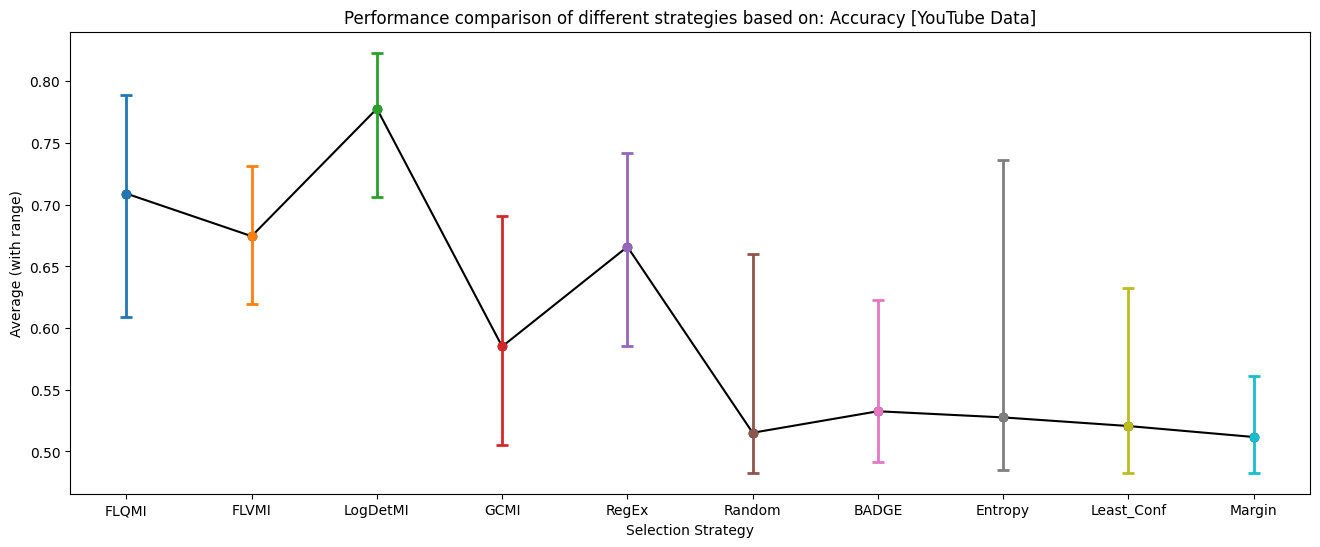

In [ ]:
graph_metric('acc')

### F-1 Score Graph

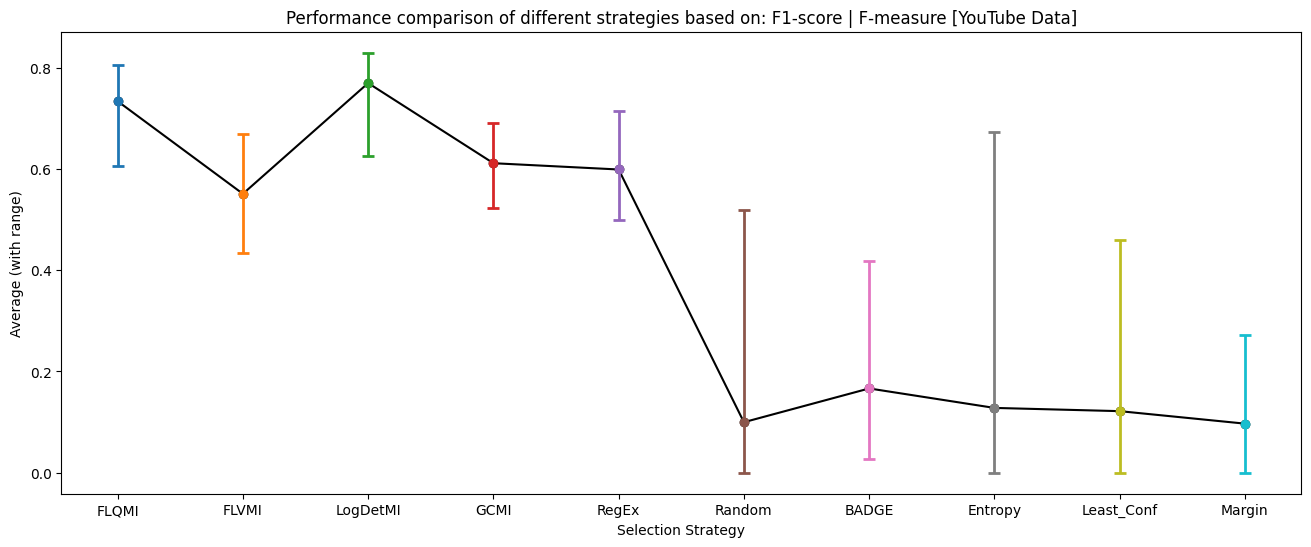

In [ ]:
graph_metric('f1')

### Precision Graphs

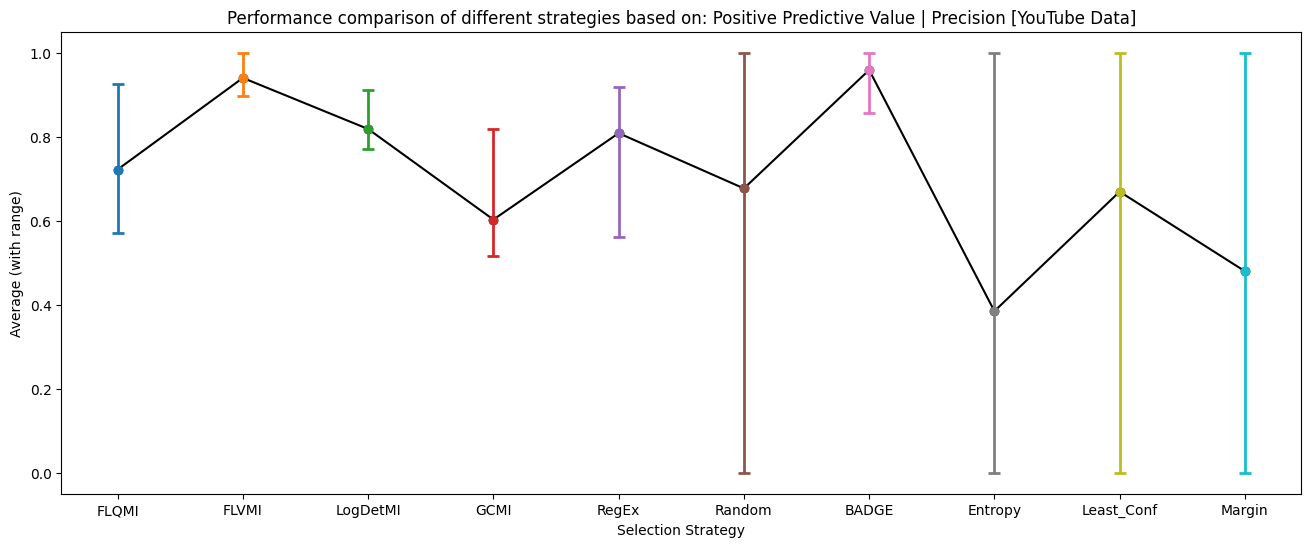

In [ ]:
graph_metric('ppv')

### Recall Graphs

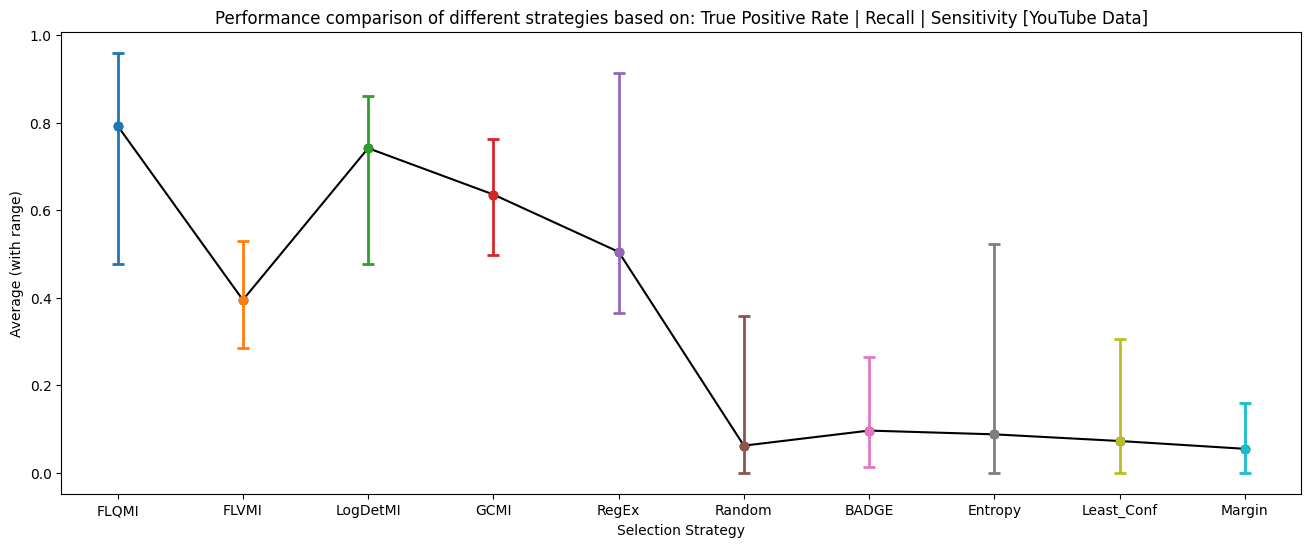

In [ ]:
graph_metric('tpr')

### Matthews Correlation Coefficient Graphs

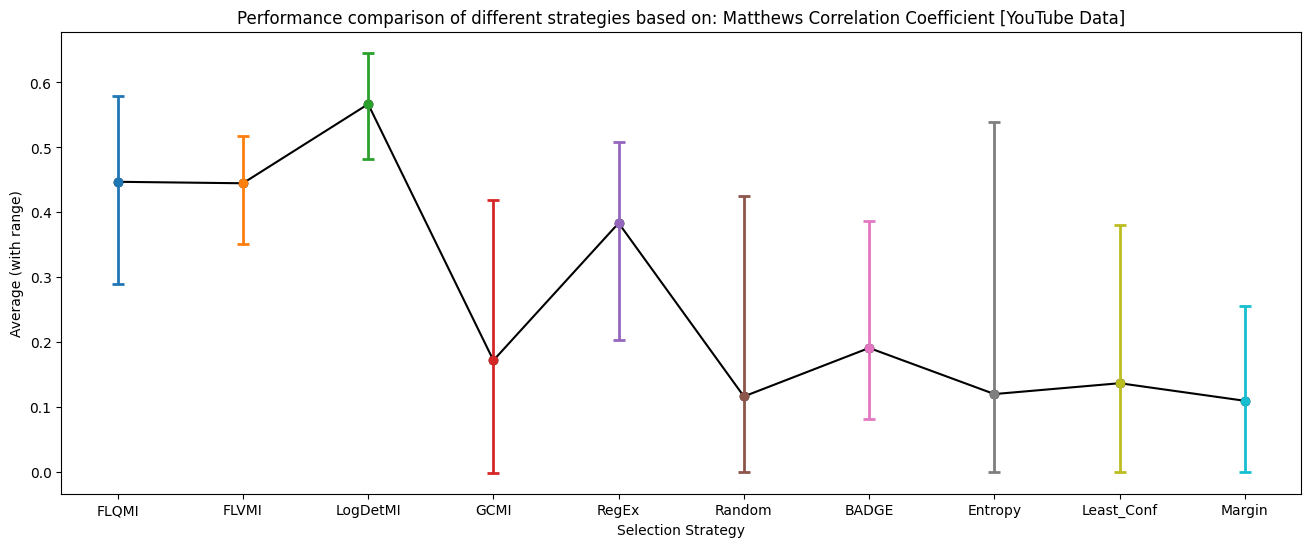

In [ ]:
graph_metric('mcc')

## Performance Graphs - Metric Variations

In [ ]:
def graph_variance(metric):

    data = Metric_stats[metric]

    # Extract data from the dictionary
    strategies = list(data.keys())
    averages = [data[strategy]['avg'] for strategy in strategies]
    std_devs = [data[strategy]['std_dev']/2 for strategy in strategies]
    colors = ['C{}'.format(i) for i in range(len(data))]  # One color for each strategy

    plt.figure(figsize=(16, 6))
    plt.bar(strategies, averages, yerr=std_devs, alpha = 0.3, capsize=5, color=colors)
    plt.xlabel('Selection Strategy')
    plt.ylabel('Average (with standard deviation)')
    plt.title('Variation in performance of different strategies based on: {} [YouTube Data]'.format(metric_dict[metric]))
    plt.show()

### Accuracy Variation

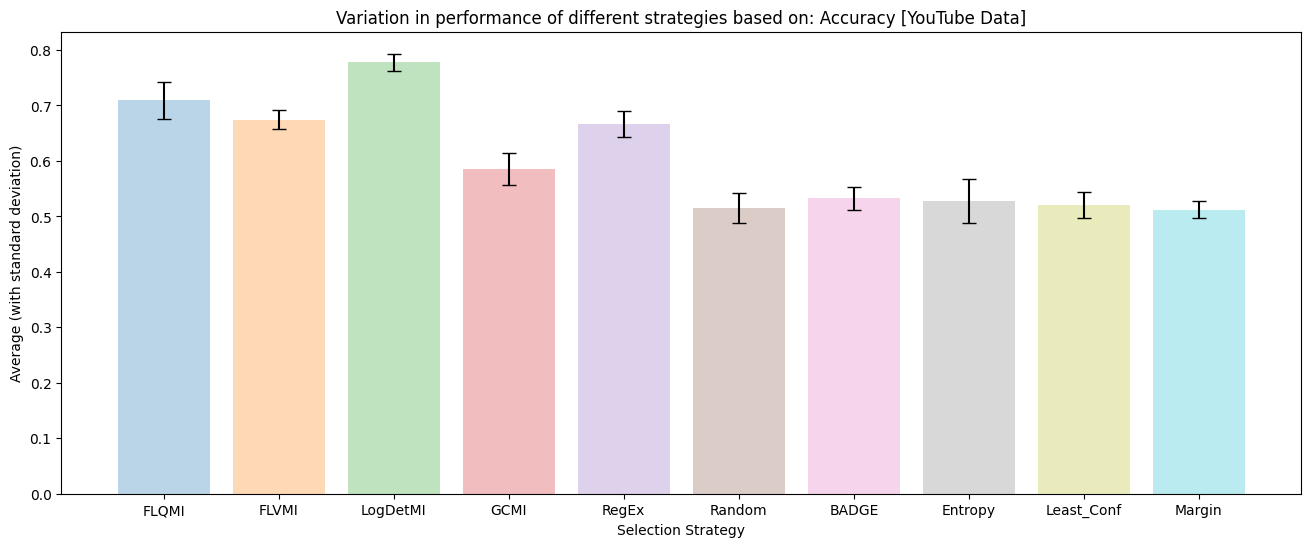

In [ ]:
graph_variance('acc')

### F1-Score Variation

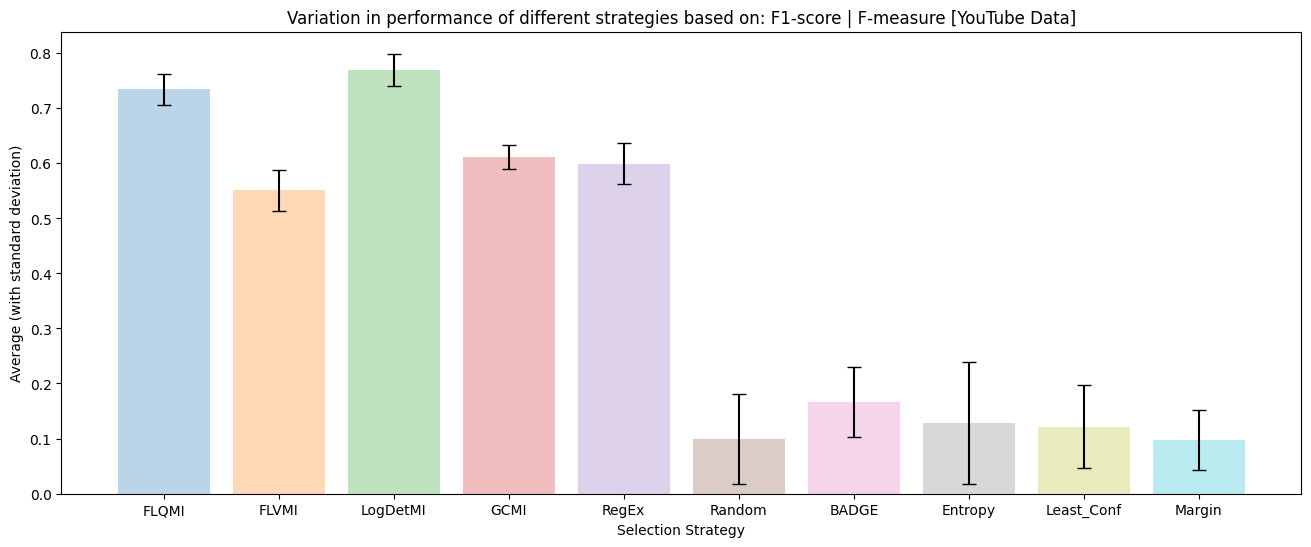

In [ ]:
graph_variance('f1')

### Precision Variation

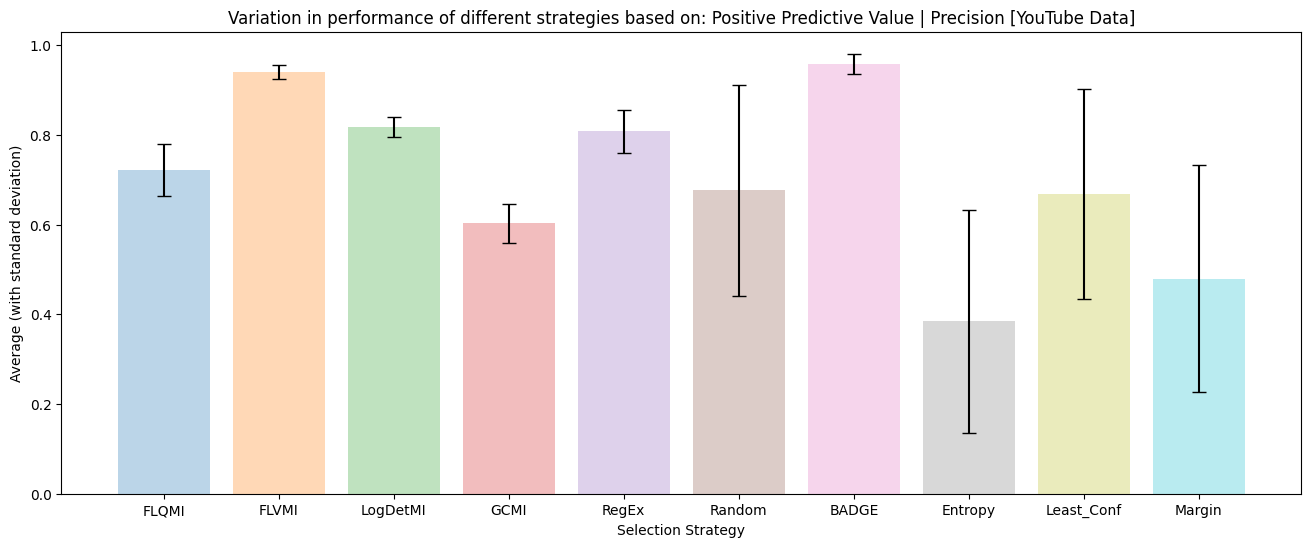

In [ ]:
graph_variance('ppv')

### Recall Variation

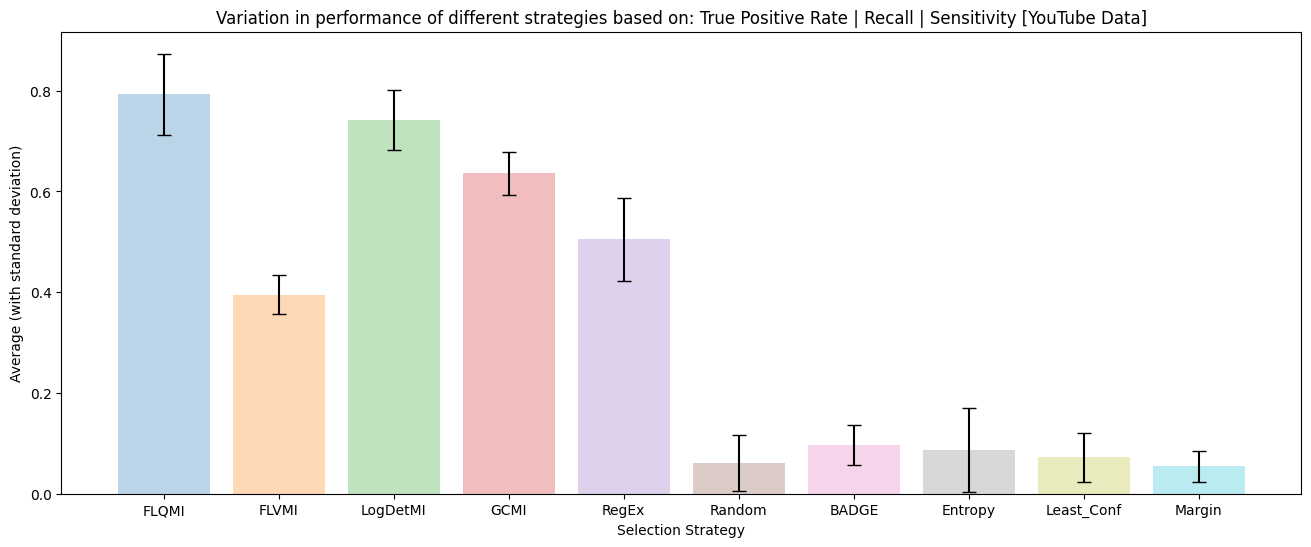

In [ ]:
graph_variance('tpr')

### Matthews Correlation Coefficient Variation

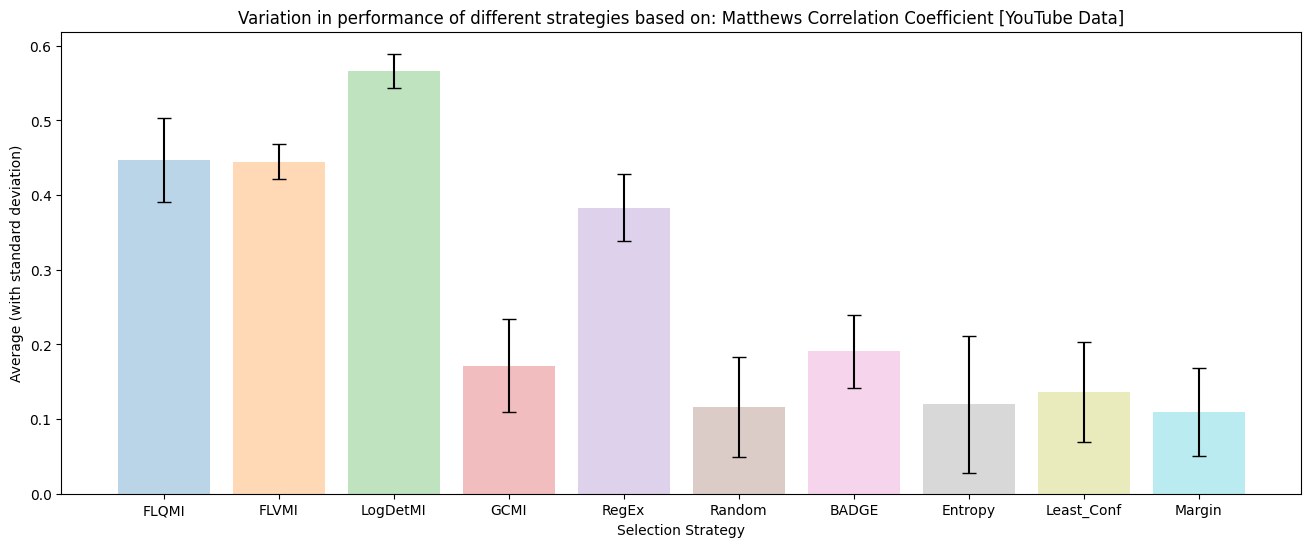

In [ ]:
graph_variance('mcc')